## Elephant$-$Donkey Problem

av Марат Богаутдинов, 232

**Аннотация**  

`Elephant — Donkey Problem` $-$ исследовательский проект, результатом которого стала обученная методами `ML` модель, классифицирующая твиты, написанные политиками-республиканцами (слоны) и политиками-демократами (ослы) в США. В рамках исследования был собран датасет из твитов 12 политиков разного уровня двух партий, сделан предварительный анализ данных, тексты были предобработаны (токенизированы, лемматизированы, лишены стоп-слов) и обучено несколько моделей, решающих задачу классификации: `kNN` и `LogReg`. В качестве признаков в матрице объектов-признаков были выбраны метаданные твитов, векторизованное представление текстов твитов, количество слов, наличие капслока, тональность твитов. Тексты были векторизованы двумя векторизаторами: с помощью `TfidfVectorizer` и встроенного векторизатора `spaCy` (набор эмбеддингов `en_core_web_md`).
  
**Задачи**  
1. Формирование датасета: краулинг данных из зеркала `X`-a и `Truth Social`
2. Предобработка данных: обработка `NaN`-значений, обработка разных типов данных
3. Обработка данных: добавление дополнительных признаков
4. EDA: формирование гипотез и их анализ через визуализацию данных
5. Подготовка данных к машинному обучению: разделение на выборки, векторизация, нормализация
6. Обучение моделей, оценка качества моделей

**Краткие результаты**  

Обученная модель логистической регрессии с показателем `accuracy = 0.89` $-$ модель обучена на данных, векторизованных методом `TF-IDF`.

**Использованные инструменты, пройденные в течение курса и примененные в работе**  

библиотеки и модули: `pandas`, `numpy`, `json`, `bs4` (`BeautifulSoup`), `re`, `scipy`, `matplotlib`, `seaborn`, `nltk`, `wordcloud`, `itertools`, `collections`, `sklearn`, `mlxtend`, `spacy`.  
  
**Важно:** при краулинге данных может быть необходим подключенный `VPN` для доступа к `X` и `Truth Social`. Пользуйтесь собранными готовыми датасетами (NB csv-файлы лежат в том же репозитории; код для чтения файлов уже написан: уберите знак однострочного комментария `#`).

### 1.&emsp;Формирование датасета: краулинг данных

**1.&emsp;Структура датасета**  
Формируем стуктуру датасета, который потом заполним данными о постах в X (ex-Twitter). Помимо самого текста поста, который будет являться ключевым признаком при классификации, мы собираем некоторые метаданные с каждого поста: время публикации поста, количество комментариев, ретвитов, цитирований и лайков.

In [1]:
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

df = pd.DataFrame(columns=['name', 'username', 'party', 'text', 
                           'datetime', 'n_comments', 
                           'n_retweets', 'n_quotes', 'n_hearts'])

**2.&emsp;Выбор политиков и ручной сбор их юзернеймов**  
Далее необходимо выбрать аккаунты политиков $-$ республиканцев и демократов. Известные политики были собраны по открытым источникам (в частности, [портал](https://today.yougov.com/topics/politics/ratings) рейтинга популярных людей), все политики $-$ сенаторы Сената США, конгрессмены Конгресса США, бывшие и нынешние представители исполнительной власти США (федерального уровня). В качестве репрезентативных аккаунтов выбирались как официальные, так и неофициальные, но только те, в которых политики публикуют посты, связанные с их политической работой. Ниже приведена таблица, в которой отражены имена политиков, их никнейм в X, занимаемая должность, партия и количество подписчиков.

| №  |       имя       |       ник        |       партия       |       должность       | подписчики (млн) |
|----|-----------------|------------------|--------------------|-----------------------|------------------|
| 01 |   Donald Trump  | @realDonaldTrump |     Republican     |       президент       |        9.31      |
| 02 |   Ron DeSantis  | @RonDeSantis     |     Republican     |      конгрессмен      |        5.7       |
| 03 |   J.D. Vance    | @JDVance         |     Republican     |     вице-президент    |        4.0       |
| 04 |   M.T. Greene   | @RepMTG          |     Republican     |     конгрессвумен     |        4.6       |
| 05 |   Josh Hawley   | @HawleyMO        |     Republican     |        сенатор        |        2.2       |
| 06 |   Mike Johnson  | @SpeakerJohnson  |     Republican     |      конгрессмен      |        1.0       |
| 07 |   Joe Biden     | @JoeBiden        |     Democratic     |      ex-президент     |        38.1      |
| 08 |   Kamala Harris | @KamalaHarris    |     Democratic     |   ex-вице-президент   |        20.9      |
| 09 |   E. Warren     | @SenWarren       |     Democratic     |       сенаторка       |        6.6       |
| 10 |   Bernie Sanders| @SenSanders      |     Democratic     |       президент       |        11.9      |
| 11 | A. Ocasio-Cortez| @AOC             |     Democratic     |     конгрессвумен     |        12.7      |
| 12 |  Hakeem Jeffries| @RepJeffries     |     Democratic     |      конгрессмен      |        0.98      |

Составим из них `json`-файл. Для начала переведем нужные строки из таблицы в строковый формат данных, который потом скормим `json.dumps()`:

In [468]:
data_str = """Donald Trump	realDonaldTrump	Republican	9.31
Ron DeSantis	RonDeSantis	Republican	5.7
J.D. Vance	JDVance	Republican	4.0
M.T. Greene	RepMTG	Republican	4.6
Josh Hawley	HawleyMO	Republican	2.2
Mike Johnson	SpeakerJohnson	Republican	1.0
Joe Biden	JoeBiden	Democratic	38.1
Kamala Harris	KamalaHarris	Democratic	20.9
E. Warren	SenWarren	Democratic	6.6
Bernie Sanders	SenSanders	Democratic	11.9
A. Ocasio-Cortez	AOC	Democratic	12.7
Hakeem Jeffries	RepJeffries	Democratic	0.98"""

In [92]:
import json

data_list = []
for line in data_str_3.split('\n'):
    name, username, party, n_subscribers = line.split('\t')
    data_list.append({
        "name": name,
        "username": username,
        "party": party,
        "n_subscribers": float(n_subscribers)
    })

politicians = json.dumps(data_list, indent=4, ensure_ascii=False)

**3.&emsp;Краулинг из зеркала X-а**  
Сформировав список интересующих политиков, мы можем перейти к краулингу данных! Так как официальный API X-а слишком дорогой, мы воспользовались зеркалом X-а, которое позиционирует себя как "free and open source alternative Twitter front-end focused on privacy and performance" $-$ [lightbrd.com](https://lightbrd.com/) или, например, [nitter.net](https://nitter.net/). Очень удобно, что кто-то настолько ценит приватность, что не защищает себя от краулинга данных, лол :))  
К сожалению, быстро выяснилось, что ни один `instance` этого зеркала не поддерживает удобный переход от страницы к странице в строке поиска, поэтому привычный и удобный метод краулинга методами библиотеки `requests` здесь не поможет. Решение, которое я нашел, $-$ библиотека `selenium`, а конкретно его модуль `webdriver`. По сути, это даже та же библиотека запросов `requests`, только более мощная: в частности, она позволяет "прокручивать" страницу дальше, полностью имитируя взаимодействие человека с браузером. Это решение мне как раз и было необходимо! [ссылка на документацию](https://www.selenium.dev/documentation/webdriver/)  
**3.1.&emsp;Функции для краулинга: `crawl_tweets` и `web_driver`**  
Однако сначала реализуем функцию `crawl_tweets`, которая, уже получив ссылку на страницу, собирает информацию со страницы и складывает ее в датафрейм `df` с помощью библиотеки `BeautifulSoup`:

In [78]:
from bs4 import BeautifulSoup
from datetime import datetime


def crawl_tweets(name, username, party, driver, df=df):
    '''
    crawls tweets from the current page and adds them to the dataframe df
    '''
    # получаем страницу, вводим парсер
    soup = BeautifulSoup(driver.page_source, 'html.parser')

    # собираем всю информацию про твиты: текст, комментарии, ретвиты, цитирования, лайки и дату публикации
    tweet_elements_texts = soup.find_all('div', {'class': 'tweet-content media-body'})
    tweet_elements_comments = soup.find_all('span', {'class': 'icon-comment'})
    tweet_elements_retweets = soup.find_all('span', {'class': 'icon-retweet'})
    tweet_elements_quotes = soup.find_all('span', {'class': 'icon-quote'})
    tweet_elements_hearts = soup.find_all('span', {'class': 'icon-heart'})
    tweet_elements_dates = soup.find_all('span', {'class': 'tweet-date'})

    # создаем списки, в которые складываем данные
    text, n_comments, n_retweets, n_quotes, n_hearts, parsed_datetime = [], [], [], [], [], []
    
    # склеиваем полученные списки так, чтобы каждая строка относилась к своему твиту
    for tweet in zip(tweet_elements_texts, tweet_elements_comments, 
                     tweet_elements_retweets, tweet_elements_quotes,
                     tweet_elements_hearts, tweet_elements_dates):
        
        text.append(tweet[0].text.strip())
        n_comments.append(tweet[1].find_next(string=True).strip())
        n_retweets.append(tweet[2].find_next(string=True).strip())
        n_quotes.append(tweet[3].find_next(string=True).strip())
        n_hearts.append(tweet[4].find_next(string=True).strip())
        raw_datetime = tweet[5].find('a')['title']
        parsed_datetime.append(int((datetime.strptime(raw_datetime, '%b %d, %Y · %I:%M %p %Z')).timestamp()))

    n_tweets = len(text)  # количество собранных со страницы постов
    
    # загружаем всю информацию с одной страницы в датафрейм
    new_rows = pd.DataFrame({'name': [name] * n_tweets, 
                            'username': [username] * n_tweets,
                            'party': [party] * n_tweets,
                            'text': text, 
                            'datetime': parsed_datetime, 
                            'n_comments': n_comments, 
                            'n_retweets': n_retweets, 
                            'n_quotes': n_quotes, 
                            'n_hearts': n_hearts})
    df = pd.concat([df, new_rows], ignore_index=True)
    
    return df

Отлично, теперь можем реализовать код бегущего по Твиттеру. И, на самом деле, на этом этапе возникают проблемы методологии исследования, которые я бы хотел здесь коротко осветить, а именно: с какого момента стоит начинать брать твиты политиков? Если учитывать, что недавно прошли выборы, на которых президентом стал республиканец, сменив президента-демократа, то хотелось бы взять равные по времени периоды власти каждого из президентов (ведь от того, представителем какой партии является президент, очевидно, зависит и риторика, и активность написания твитов разными политиками). Однако, как мне кажется, датасет из твитов меньше чем за год является недостаточным по объему и повлияет на предсказательную способность модели.  
С другой стороны, возможно, то разнообразие политиков, с которым мы работаем (конгрессменов, сенаторов, президентов и вице-президентов), обеспечивает определенную стабильность, ведь у каждого из политических представителей свой электоральный цикл. Если допускать, что перед каждыми своими выборами политик ведет себя более активно, чем сильно до или после них, то мы можем ожидать более-менее равномерное распределение твитов (и их стилистику) по каждой партии по почти любому выбранному периоду. Последние президентские выборы США состоялись 5 ноября 2024 года, последние крупные выборы в Сенат $-$ 8 ноября 2022 года. Республиканец Трамп объявил о начале предвыборной гонки 15 ноября 2022 года, демократ Джо Байден $-$ 25 апреля 2023 года, демократка Камала Харрис $-$ 21 июля 2024 года.  
Возможно, эти методологические проблемы повлияют на нашу модель отрицательно. Однако мы приняли решение принять все прочие равными и просто собрать все твиты, начиная с 21 марта 2024 года как с даты, относительно близкой к выборам 2024 года (+ твиты ровно за 1 год).  
Реализуем функцию `web_driver`, которая посещает страницы политиков в X-е, вызывает внутри себя краулерную функцию `crawl_tweets` и прокручивает посты на одну страницу дальше:

In [ ]:
# pip install selenium

In [102]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
import time
import random


def web_driver(name, username, party, df=df):
    # настраиваем webdriver
    options = Options()
    # options.add_argument("--headless=new")  # чтобы не открывалось окно браузера (если убрать, то мы будем видеть, что конкретно делает webdriver
    options.add_argument("--disable-blink-features=AutomationControlled")  # добавляем аргумент, который скрывает факт автоматического парсинга от защиты сайтов
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
    
    # указываем наш url зеркала X-а и передаем 
    url = f"https://nitter.net/{username}"
    driver.get(url)

    # создаем границу по времени
    date_str = '23 March 2024'
    date_obj = datetime.strptime(date_str, '%d %B %Y')
    time_stop = int(date_obj.timestamp()) 
    
    # собираем твиты на начальной странице
    df = crawl_tweets(name=name, username=username, party=party, df=df, driver=driver)

    page = 1
    # цикл, который прокручивает ленту до тех пор, пока не перейдена граница по времени
    while df['datetime'].tail(1).values[0] > time_stop:
        try:
            # прогружаем show-more кнопку
            load_more_button = WebDriverWait(driver, 12).until(
                EC.presence_of_element_located((By.XPATH, "//div[@class='show-more']"))
            )
            load_more_link = load_more_button.find_element(By.TAG_NAME, "a")
    
            # кликаем ссылку
            driver.execute_script("arguments[0].click();", load_more_link)
            time.sleep(random.uniform(5, 6))  # ждем, пока прогрузятся твиты
    
            # с новой страницы собираем данные
            df = crawl_tweets(name=name, username=username, party=party, df=df, driver=driver)
            page += 1
            print(f'{name} - page completed {page}')
    
        except Exception as e:
            print('Ehh bruh something went wrong, sorry mate', e)
            break
    
    # закрываем селениум
    driver.quit()

    return df

**3.2.&emsp;Наконец, сам краулинг**  
В процессе краулинга выяснилось, что эти зеркала Твиттера не хранят так много информации, как я хотел бы получить: каждый аккаунт возможно прогрузить максимум на 40-45 страниц, что эквивалентно примерно 800 твитам. Иными словами, для почти всех аккаунтов были накраулены не все твиты, начиная с 21 марта 2024 года, как изначально планировалось. Однако мы все равно оставили эту временную границу: так все твиты будут примерно в одном временном периоде, который контролируем мы, а не привычка некоторых политиков писать редко. То есть если какие-то из политиков написали меньше 800 постов за год, то мы все равно возьмем не 800 (предельное доступное для краулинга число постов), а фактическое число за год.  

Сделав такую оговорку, мы можем запустить процесс краулинга:

In [469]:
# здесь отсутствует output, потому что, уже все собрав, я случайно запустил эту ячейку снова
# и мне пришлось прервать kernel, чтобы он не собирал данные еще 5 часов

In [ ]:
from tqdm import tqdm

for politician in tqdm(json.loads(politicians)):
    if politician["name"] != 'Donald Trump':
        df = web_driver(politician["name"], 
                   politician["username"], 
                   politician["party"], 
                   df=df)

In [138]:
# сохраним, что собрали
df.to_csv("scraped_posts_11.csv", index=False)

**4.&emsp;Краулинг с официального сайта `Truth Social`**  
Из-за того, что аккаунт Трампа оказался забанен Твиттером, он перешел на свою собственную платформу [Truth Social](https://truthsocial.com/@realDonaldTrump). Поэтому для того чтобы получить твиты Дональда Трампа, нам придется немного переделать код выше под краулер с сайта `Truth Social`. (Обернуть оба краулера красиво функциями не получилось, слишком много изменений :( )  
**4.1.&emsp;Функции для краулинга: `crawl_tweets_truth`, `get_links` и `web_driver_truth`**  
Включенный `JavaScript` на сайте `Truth Social` обновляет посты в треде автоматически при прокручивании страницы вниз, а в html-коде страницы нет никакой ссылки, которая бы отвечала за это переключение. Не найдя достойных решений для этой проблемы, зато обнаружив сводный сайт всех постов Трампа со ссылкой на источник $-$ [`Trump's Truths`](https://trumpstruth.org/) $-$ мы решили сделать так: отдельно собрать все ссылки на посты Трампа с сайта $-$ агрегатора его постов, а потом идти по ссылкам и доставать оттуда всю дату. К сожалению, на этом сайте-агрегаторе из доступной даты были только сам текст и дата, что нам никак не подходило. Итак, функции: 
- `web_driver_truth` $-$ ходит по сайту [`Trump's Truths`](https://trumpstruth.org/), вызывает функцию `get_links`, возвращает список ссылок на посты Трампа в `Truth Social`;
- `get_links` $-$ функция, которая получает на вход страницу из агрегатора постов Трампа и извлекает оттуда все ссылки на оригинальные посты Трампа, возвращает список ссылок на отдельной странице агрегатора постов Трампа;
- `crawl_tweets_truth` $-$ получает на вход список ссылок на оригинальные посты Трампа в `Truth Social` и извлекает из каждого поста всю интересующую информацию: текст, количество лайков, ретвитов (retruths), комментариев (replies) и дату публикации поста.

In [395]:
def crawl_tweets_truth(links):
    '''
    crawls tweets from the current page and adds them to the dataframe df: works for Truth Social
    '''
    trump_dict = {'text': [], 
                  'datetime': [], 
                  'n_comments': [], 
                  'n_retweets': [],
                  'n_hearts': []}
    
    for link in tqdm(links):
        try:
            # заводим селениум
            options = Options()
            # запускаем webdriver
            driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
            driver.set_window_size(600, 400)
            driver.get(link)
            time.sleep(0.2)

            # все извлекаем
            try:
                tweet_element_text = driver.find_elements(By.CLASS_NAME, 'flex.flex-col.space-y-4')
                text = tweet_element_text[1].text
            except Exception:
                text = ''
            
            try:
                tweet_elements = driver.find_elements(By.CLASS_NAME, 'flex.rtl\\:space-x-reverse.items-center.space-x-1')
                n_hearts = tweet_elements[3].text.split()[0].strip()
                n_retweets = tweet_elements[2].text.split()[0].strip()
                parsed_datetime = datetime.strptime(tweet_elements[4].text.strip(), '%b %d, %Y, %I:%M %p').timestamp()
            except Exception:
                n_hearts = '0'
                n_retweets = '0'
                parsed_datetime = None
            
            try:
                tweet_comments = driver.find_elements(By.CLASS_NAME, 'flex.flex-col')
                n_comments = tweet_comments[0].text.split()[3]
            except Exception:
                n_comments = '0'

            driver.quit()

            # добавляем в словарик
            trump_dict['text'].append(text)
            trump_dict['datetime'].append(parsed_datetime) 
            trump_dict['n_comments'].append(n_comments) 
            trump_dict['n_retweets'].append(n_retweets)
            trump_dict['n_hearts'].append(n_hearts)
        
        except Exception as e:
             print('probably, the post was deleted')
    
    return trump_dict

In [146]:
def get_links(driver):
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    link_tags = soup.select("div.status-header__right a.status__external-link")
    links = [link["href"] for link in link_tags]
    return links

In [308]:
def web_driver_truth(page_max=30):
    # настраиваем webdriver
    options = Options()
    options.add_argument("--headless=new")  # чтобы не открывалось окно браузера (если убрать, то мы будем видеть, что конкретно делает webdriver
    options.add_argument("--disable-blink-features=AutomationControlled")  # добавляем аргумент, который скрывает факт автоматического парсинга от защиты сайтов
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
    
    # указываем наш url зеркала X-а и передаем 
    url = 'https://trumpstruth.org/?per_page=50'
    driver.get(url)

    links = []
    links.extend(get_links(driver=driver))
    
    page = 1
    # цикл, который прокручивает ленту до тех пор, пока не перейдена граница по времени
    while page < page_max:
        try:
            # прогружаем show-more кнопку
            load_more_button = WebDriverWait(driver, 12).until(
                EC.presence_of_element_located((By.XPATH, "//div[@class='pagination controls__pagination']"))
            )
            load_more_links = load_more_button.find_elements(By.TAG_NAME, "a")

            if len(load_more_links) > 1:
                load_more_link = load_more_links[1]
            else:
                load_more_link = load_more_links[0]
    
            # кликаем ссылку
            driver.execute_script("arguments[0].click();", load_more_link)
            time.sleep(random.uniform(5, 6))  # ждем, пока прогрузятся твиты

            # с новой страницы собираем данные
            links.extend(get_links(driver=driver))
            page += 1
    
        except Exception as e:
            print('Ehh bruh something went wrong, sorry mate', e)
            break
    
    # закрываем селениум
    driver.quit()

    return links

**4.2.&emsp;Краулим посты Трампа из `Truth Social`**  
Сначала получаем ссылки на посты Трампа в переменную `links`, потом ходим по ссылкам, заполняя словарь `trump_dict`:

In [313]:
links = web_driver_truth(18)

In [396]:
# тестово проверим на 100 постах
trump_dict_100 = crawl_tweets_truth(links[:100])

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [20:00<00:00, 12.00s/it]


In [405]:
# а теперь соберем оставшиеся
trump_dict_819 = crawl_tweets_truth(links[100:])

100%|██████████████████████████████████████████████████████████████████████████████| 819/819 [2:41:20<00:00, 11.82s/it]


In [411]:
trump_df = pd.concat([pd.DataFrame(trump_dict_100), pd.DataFrame(trump_dict_819)], ignore_index=True)
trump_df.tail()

text      datetime  \
914  Tomorrow, as promised, President @realDonaldTr...  1.737318e+09   
915  BREAKING: First January 6th political prisoner...  1.737434e+09   
916  Anybody that’s against Tariffs, including the ...  1.738539e+09   
917  The water is flowing in California. These once...  1.738539e+09   
918  South Africa is confiscating land, and treatin...  1.738538e+09   

    n_comments n_retweets n_hearts  
914        869      4.11k    20.1k  
915        224      2.67k    15.7k  
916       5463      14.7k      64k  
917       2274      10.6k    44.4k  
918       2465       9.4k    38.6k

In [407]:
# сохраним, что собрали
df.to_csv("scraped_posts_trump.csv", index=False)

**4.3.&emsp;Добавляем `name`, `username`, `party` в `trump_df` и конкатенируем с уже имеющимся датафреймом `df`**  

In [408]:
# для проверки дальнейшего кода скачайте датасеты из файлов: файлы находятся в репозитории с готовым проектом

# trump_df = pd.read_csv('scraped_posts_trump.csv')
# df = pd.read_csv('scraped_posts_11.csv')

Отлично, посты скраулились аккуратно. Теперь добавим информацию про Трампа и объединим с основным датафреймом:

In [412]:
# добавляем имя, юзернейм и партию
trump_df['name'] = ['Donald Trump'] * 919
trump_df['username'] = ['realDonaldTrump'] * 919
trump_df['party'] = ['Republican'] * 919
trump_df.tail(2)

text      datetime  \
917  The water is flowing in California. These once...  1.738539e+09   
918  South Africa is confiscating land, and treatin...  1.738538e+09   

    n_comments n_retweets n_hearts          name         username       party  
917       2274      10.6k    44.4k  Donald Trump  realDonaldTrump  Republican  
918       2465       9.4k    38.6k  Donald Trump  realDonaldTrump  Republican

Объединяем Трампа с остальными политиками:

In [413]:
df = pd.concat([df, trump_df], ignore_index=True)
df.tail(2)

name         username       party  \
8684  Donald Trump  realDonaldTrump  Republican   
8685  Donald Trump  realDonaldTrump  Republican   

                                                   text      datetime  \
8684  The water is flowing in California. These once...  1738539060.0   
8685  South Africa is confiscating land, and treatin...  1738538340.0   

     n_comments n_retweets n_quotes n_hearts  
8684       2274      10.6k      NaN    44.4k  
8685       2465       9.4k      NaN    38.6k

Сохраним датасет:

In [414]:
df.to_csv('tweets_all.csv', index=False)

У нас готов сырой датасет! Теперь можем заняться exploratory data analysisом!

### 2.&emsp;EDA: анализ, предобработка и обработка данных

In [57]:
# df = pd.read_csv('tweets_all.csv')

**1.&emsp;Делаем предварительный анализ данных**  
Давайте вообще посмотрим, что получилось:

In [58]:
df.sample(3)

name      username       party  \
2175      Joe Biden      JoeBiden  Democratic   
1065  Kamala Harris  KamalaHarris  Democratic   
3098    M.T. Greene        RepMTG  Republican   

                                                   text      datetime  \
2175  I’m going to protect Social Security and Medic...  1.717333e+09   
1065  On day one, Donald Trump would walk into the O...  1.730303e+09   
3098  “Rep. Marjorie Taylor Greene (R-GA) directed h...  1.736285e+09   

     n_comments n_retweets n_quotes n_hearts  
2175     10,438      4,765      682   23,530  
1065      4,057      1,983      229    8,513  
3098        911        388       55    2,151

**2.&emsp;Делаем предварительный анализ данных и ✨магические трансформации✨**  
Нас интересуют, насколько тот датасет, который есть у нас на руках, полноценен. А если он в некоторых местах ущербен, то попробуем это изменить.   
**2.1.&emsp;Формат данных**  
Посмотрим, каких форматов данные в датасете, и при необходимости постараемся сразу это изменить:

In [59]:
df.dtypes

name           object
username       object
party          object
text           object
datetime      float64
n_comments     object
n_retweets     object
n_quotes       object
n_hearts       object
dtype: object

Что ж, придется привести все колонки к нужным типам данных:

In [63]:
df = df.rename(columns={'datetime': 'timestamp'})
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s', errors='ignore')
df.dtypes

name                  object
username              object
party                 object
text                  object
timestamp            float64
n_comments            object
n_retweets            object
n_quotes              object
n_hearts              object
datetime      datetime64[ns]
dtype: object

In [65]:
import re

def convert_to_int(value):
    if isinstance(value, str):
        value = value.replace(",", "")

        # там есть еще k у лайков из Truth Social, их тоже нужно обработать
        match = re.match(r"(\d+\.?\d*)([km]?)$", value)
        if match:
            num, suffix = match.groups()
            num = float(num)
            if suffix.lower() == 'k':
                num *= 1000
            elif suffix.lower() == 'm':
                num *= 1000000
            return int(num)
    
    return int(value) if str(value).isdigit() else None

In [66]:
df[['n_comments', 'n_hearts', 'n_quotes', 'n_retweets']] = df[['n_comments', 'n_hearts', 'n_quotes', 'n_retweets']].applymap(convert_to_int)
df.dtypes

name                  object
username              object
party                 object
text                  object
timestamp            float64
n_comments           float64
n_retweets           float64
n_quotes             float64
n_hearts               int64
datetime      datetime64[ns]
dtype: object

Отлично, все данные в нужных форматах. Теперь с ними можно работать и преобразовывать их.

**2.2.&emsp;Отсутствующие значения**  
Посчитаем количество `NaN` значений и решим, что с ними делать

In [67]:
df.isnull().sum()

name             0
username         0
party            0
text           147
timestamp       47
n_comments      27
n_retweets    1222
n_quotes      1014
n_hearts         0
datetime        47
dtype: int64

**2.2.1.**&emsp;Давайте посмотрим на некоторые нулевые значения. Например, у кого из политиков ноль лайков:

In [98]:
print(f'политики: {' '.join([p for p in df[df['n_hearts'] == 0]['name'].unique()])}\n' 
      f'количество пропусков: {df[df['n_hearts'] == 0]['n_hearts'].count()}')

политики: Donald Trump
количество пропусков: 47


Понятно: в тех тех случаях, когда пост Трампа был, например, удален или почему-то был недоступен, обязательно вставлялись значения-пустышки. Удалим все такие строки:

In [171]:
new_df = df[df['n_hearts'] != 0]
df.shape, new_df.shape

((8686, 10), (8639, 10))

Отлично, удалили ровно 47 строк. Очевидно, что те же пустышки во всех остальных строках, поэтому в `timestamp`, `datetime` не осталось `NaN` значений.  
**2.2.2.**&emsp;В остальных случаях ситуация отличается: почти точно отсутствующие значения будут у разных политиков, а не только у Трампа. Посмотрим, у кого из политиков есть нули в остальных признаках:

In [173]:
new_df.groupby('name')[['n_comments', 'n_retweets', 'n_quotes']].apply(lambda g: g.isna().sum())

n_comments  n_retweets  n_quotes
name                                              
A. Ocasio-Cortez           1         265         2
Bernie Sanders             0           5        10
Donald Trump               0           0       872
E. Warren                  0          83        17
Hakeems Jeffries           0          20         0
J.D. Vance                 0         178         1
Joe Biden                  0         105         0
Josh Hawley                1         226        48
Kamala Harris              0          71         0
M.T. Greene                0          64         3
Mike Johnson               0         193        14
Ron DeSantis               0          12         0

Достаточно много пустых значений, поэтому удалять строки с пустыми значениями точно не вариант. Очевидно, их нужно заполнить, и есть несколько вариантов:  
- средними или медианными значениями?
- рассчитывать среднее/медиану по всему датасету или по конкретному политику?  

Кажется, что мы бы хотели получить более точные значения, поэтому рассчитывать отсутствующие значения мы предлагаем все-таки по каждому конкретному политику, исходя из имеющихся о не:й данных.
Что касается расчета среднего или медианного значения, то тут нужно проанализировать распределение существующих значений. Дело в том, что на расчет среднего сильно влияют выбросы, что собьет правдоподобное значение, которое мы бы хотели получить. Поэтому чтобы заполнить данные средними значениями, хорошо бы проверить, как распределены значения сейчас.
Медианное заполнение хорошо тем, что избегает проблемы выбросов, однако, очевидно, чуть хуже отражает реальные значения.

Заметим также, что нам скорее интересно проверить распределение для колонки `n_retweets`, как самой affected отсутствующими значениями. И примем эвристику, что то же распределение в `n_quotes`, чтобы лишний раз не считать распределение. Распределение же удобно посчитать несколькими методами из библиотеки для статистических вычислений `scipy`.  
Давайте посмотрим, что мы имеем:

In [109]:
# pip install scipy

In [174]:
import numpy as np
from scipy.stats import skew, kurtosis

n_retweets_no_na = new_df.dropna(subset=['n_retweets'])
stats = n_retweets_no_na.groupby('name')['n_retweets'].agg(
        skewness=lambda x: skew(x),  
        kurtosis=lambda x: kurtosis(x)
    ).reset_index()

print(stats)

                name   skewness    kurtosis
0   A. Ocasio-Cortez   4.304607   28.451438
1     Bernie Sanders   4.438547   25.458465
2       Donald Trump   1.941300    6.375940
3          E. Warren   6.934049   79.037645
4   Hakeems Jeffries   7.238519   75.917092
5         J.D. Vance   3.493813   18.449861
6          Joe Biden  11.625116  169.400544
7        Josh Hawley   9.811102  148.862076
8      Kamala Harris   4.404915   28.797220
9        M.T. Greene   7.562534   89.241555
10      Mike Johnson   5.369313   37.059626
11      Ron DeSantis   2.529577    6.640809


Интерпретация:  
- `skewness` $-$ это метрика, отвечающая за симметричность данных: `0` при симметричных данных, `<0` при данных, смещенных влево, `>0` при данных смещенных вправо; 
- `kurtosis` $-$ это метрика, отвечающая за "тяжесть" хвостов (по-русски это коэффициент эксцесса): `0` при нормальном распределении, `<0` при "легких" хвостах (т.е. по бокам случайная величина распределена мало), `>0` при "тяжелых" хвостах (т.е. по бокам случайная величина распределена много).

Как мы видим, распределения величин "количество ретвитов с аккаунта" смещены вправо, а пик у всех распределений в какой-то мере "прижат" книзу. Давайте теперь визуализируем эти распределения:

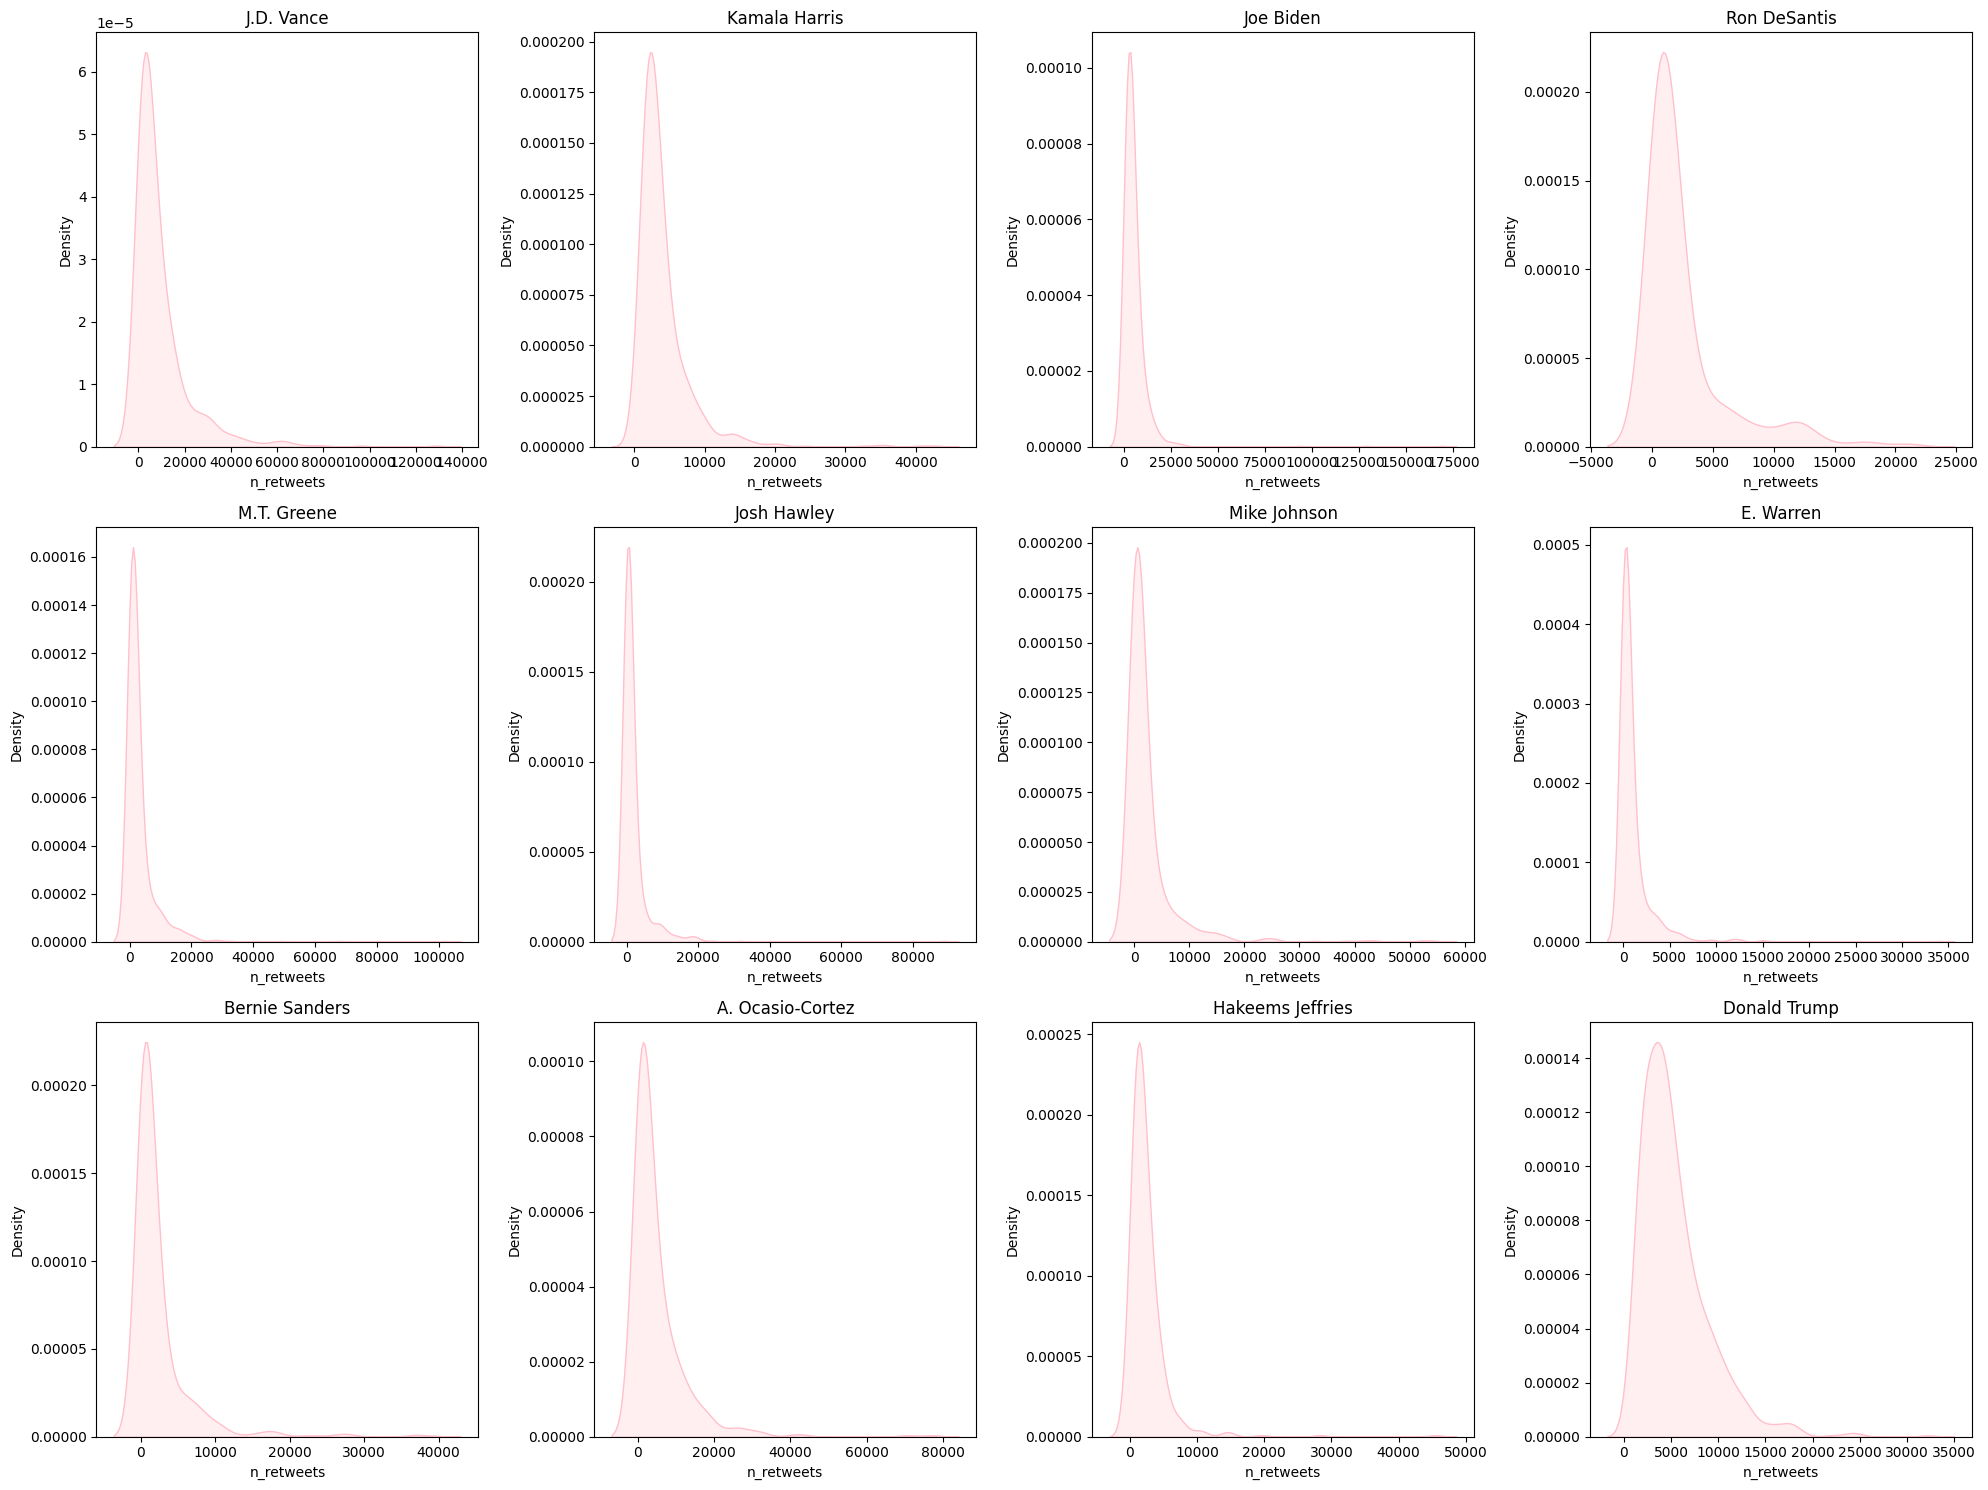

In [175]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_distribution(df=new_df, name='name', retweets='n_retweets'):

    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    axes = axes.flatten()
    
    groups = df[name].unique()
    for i, group in enumerate(groups):
        subset = df[df[name] == group][retweets].dropna()
        sns.kdeplot(subset, ax=axes[i], color='pink', fill=True)
        axes[i].set_title(f"{group}")

    plt.tight_layout()
    plt.show()

plot_distribution()

Отлично, тогда заполним медианными значениями:

In [176]:
fill_cols = ['n_retweets', 'n_quotes', 'n_comments']  # выбираем колонки для преобразования
fill_values = new_df.groupby('name')[fill_cols].transform('median')  # вычисляем медианные значения
new_df[fill_cols] = new_df[fill_cols].fillna(fill_values)  # заполняем NaN медианами

new_df.groupby('name')[['n_comments', 'n_retweets', 'n_quotes']].apply(lambda g: g.isna().sum())

n_comments  n_retweets  n_quotes
name                                              
A. Ocasio-Cortez           0           0         0
Bernie Sanders             0           0         0
Donald Trump               0           0       872
E. Warren                  0           0         0
Hakeems Jeffries           0           0         0
J.D. Vance                 0           0         0
Joe Biden                  0           0         0
Josh Hawley                0           0         0
Kamala Harris              0           0         0
M.T. Greene                0           0         0
Mike Johnson               0           0         0
Ron DeSantis               0           0         0

**2.2.3.**&emsp;В случае с `n_quotes` Дональда Трампа, которое нельзя было получить из `Truth Social`, заполним это значение медианой по всей колонке. Однако сперва проверим распределение:

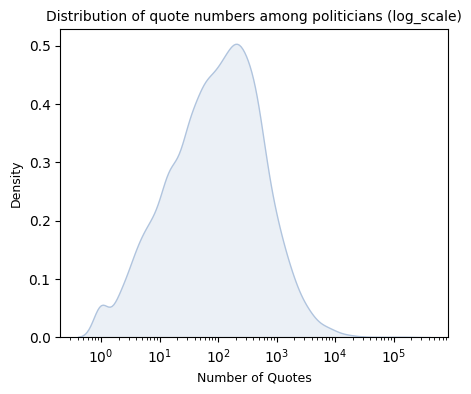

In [177]:
plt.figure(figsize=(5, 4))
sns.kdeplot(new_df['n_quotes'], color='lightsteelblue', fill=True, log_scale=True)
plt.title('Distribution of quote numbers among politicians (log_scale)', fontsize=10)
plt.xlabel('Number of Quotes', fontsize=9)
plt.ylabel('Density', fontsize=9)
plt.show()

In [178]:
fill_value = new_df['n_quotes'].median()  # вычисляем медиану
new_df.loc[new_df['name'] == 'Donald Trump', 'n_quotes'] = (
    new_df.loc[new_df['name'] == 'Donald Trump', 'n_quotes'].fillna(fill_value)
)

new_df.isnull().sum()

name            0
username        0
party           0
text          131
timestamp       0
n_comments      0
n_retweets      0
n_quotes        0
n_hearts        0
datetime        0
dtype: int64

**2.2.4.**&emsp;И теперь насчет текстов. Кажется, во всех случаях это просто пустые строки. Если это так, то ничего страшного, так и оставим:

In [179]:
new_df[new_df['text'].isna() == True].sample(2)

name         username       party text     timestamp  \
8532  Donald Trump  realDonaldTrump  Republican  NaN  1.739334e+09   
109     J.D. Vance          JDVance  Republican  NaN  1.738601e+09   

      n_comments  n_retweets  n_quotes  n_hearts            datetime  
8532      1026.0      7300.0     101.0     37700 2025-02-12 04:14:00  
109        281.0     40653.0      44.0      8723 2025-02-03 16:40:00

In [180]:
new_df['text'] = new_df['text'].fillna('')

Готово! Теперь наш датасет полностью готов к настоящим преобразованиям

**3.&emsp;Добавляем новые признаки**  
Как минимум, мы хотим добавить обработанный текст, а из него уже получить векторизованное представление. А еще ввести некоторые дополнительные признаки.  
**3.1.&emsp;Новый признак: длина текста**  
Возможно, это нам еще пригодится: мы предполагаем, что республиканцы и демократы по какой-то причине пишут более длинные твиты, но не уверены в этом. Давайте попробуем ввести такой признак:

In [187]:
new_df['length'] = new_df['text'].apply(lambda text: len(text.split()))
new_df[['text', 'length']].sample(2)

text  length
3300  “President-elect Trump’s effort to drain the s...      40
382   Saint Michael the Archangel, defend us in batt...      60

**3.2.&emsp;Новый признак: использование капслока**  
Еще один признак $-$ это использование капслока. Дело в том, что чисто визуально, по крайней мере, Дональд Трамп и некоторые другие республиканцы, чаще демократов используют текст, написанный капслоком. Давайте введем признак, который флажирует, использовался ли в твите капслок:

In [220]:
new_df['capslock'] = new_df['text'].apply(
    lambda text: 1 if sum(x.isupper() and len(x) > 1 for x in text.split()) > 0 else 0
)
new_df[['name', 'text', 'capslock']].sample(2)

name                                               text  \
2672    M.T. Greene  President Trump has endorsed my Gulf of Americ...   
1581  Kamala Harris         When unions are strong, America is strong.   

      capslock  
2672         1  
1581         0

**3.3.&emsp;Препроцессинг текстов**  
Обработаем тексты: токенизируем, лемматизируем и уберем стоп-слова:

In [225]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if not isinstance(text, str):  
        return ''
    
    words = word_tokenize(text.lower())
    words = [lemmatizer.lemmatize(word) for word in words 
             if word.isalpha() and word not in stop_words]
    return ' '.join(words)

new_df['preprocessed'] = new_df['text'].apply(preprocess_text)

In [228]:
new_df.sample(2)

name        username       party  \
5320     E. Warren       SenWarren  Democratic   
4974  Mike Johnson  SpeakerJohnson  Republican   

                                                   text     timestamp  \
5320  Donald Trump and Elon Musk’s idea of efficienc...  1.739548e+09   
4974  How? In nearly every state today, a noncitizen...  1.726151e+09   

      n_comments  n_retweets  n_quotes  n_hearts            datetime  length  \
5320      2163.0      2262.0     107.0      1603 2025-02-14 15:55:00      14   
4974        27.0        66.0       5.0       362 2024-09-12 14:17:00      46   

      capslock                                       preprocessed  
5320         0  donald trump elon musk idea efficiency stoppin...  
4974         1  nearly every state today noncitizen walk dmv w...

**3.4.&emsp;Новый признак: тональность**  
Для этого воспользуемся бинарным классификатором из NLP библиотеки `nltk`. Он относительно хорошо справляется с короткими текстами, он lexicon-based, поэтому работает быстро:

In [505]:
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

new_df = new_df.reset_index(drop=True)
ton = new_df['text'].apply(
    lambda text: sia.polarity_scores(text)
)

# не берем в столбец neutral, чтобы не было автокорреляции
new_df[['ton_neg', 'ton_pos', 'ton_compound']] = pd.DataFrame(ton.tolist())[['neg', 'pos', 'compound']]

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\mboga\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [507]:
new_df.sample(2)

name         username       party  \
7525  Hakeems Jeffries      RepJeffries  Democratic   
8508      Donald Trump  realDonaldTrump  Republican   

                                                   text     timestamp  \
7525  Today is the 30th Anniversary of the Far Right...  1.727428e+09   
8508  FEMA spent tens of millions of dollars in Demo...  1.739288e+09   

      n_comments  n_retweets  n_quotes  n_hearts            datetime  length  \
7525      5156.0       769.0     310.0      6590 2024-09-27 09:01:00      35   
8508      4773.0     15300.0     101.0     63600 2025-02-11 15:29:00      62   

      capslock                                       preprocessed  ton_neg  \
7525         1  today anniversary far right contract america d...    0.060   
8508         1  fema spent ten million dollar democrat area di...    0.161   

      ton_pos  ton_compound  
7525    0.041       -0.1779  
8508    0.083       -0.7886

Кажется, больше вытянуть уже ничего не получится. Давайте перейдем к анализу данных и их визуализации.

**4.&emsp;Визуализация и анализ данных**  
Сейчас нам интересно посмотреть, подтверждаются ли какие-либо из следующих гипотез:  
- твиты республиканцев короче, чем демократов;
- и республиканцы, и демократы получают примерно равно количество маркеров активности аудитории (лайки, комментарии, ретвиты, цитирования);
- и у республиканцев, и у демократов будут примерно одинаковые наиболее частотные слова;
- тональность твитов республиканцев отрицательнее, чем твитов демократов;
  - узкая гипотеза: тональность твитов республиканцев принимает большее по модулю значение, чем у демократов (иными словами, их твиты более эмоциональные);
- республиканцы чаще используют капслок, чем демократы;
  - узкая гипотеза: Трамп чаще остальных использует капслок.

Обозначив некоторые предположения, можем строить графики.

**4.1.&emsp;Гипотеза #1 $-$ длина твитов**  
Мы предполагаем, что твиты республиканцев короче, чем демократов

<Figure size 800x600 with 0 Axes>

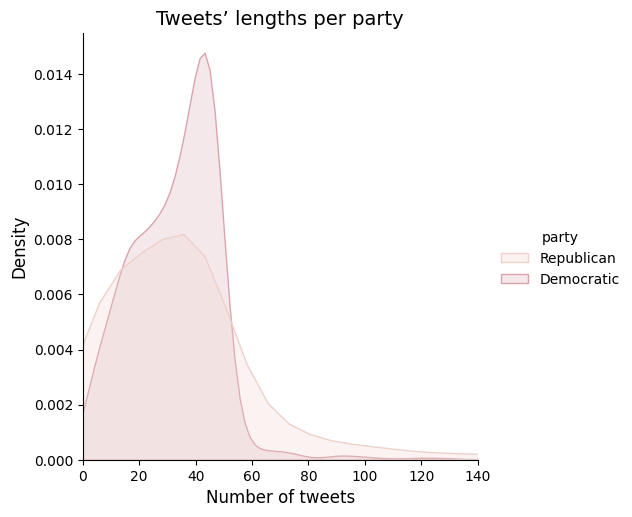

In [508]:
plt.figure(figsize=(8, 6))
sns.displot(data=new_df, x='length', hue='party', palette=sns.cubehelix_palette(), fill=True, kind='kde')
plt.xlim(0, 140)
plt.title('Tweets’ lengths per party', fontsize=14)
plt.xlabel('Number of tweets', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.show()

**Вывод: гипотеза не подтвердилась**  
Демократы пишут твиты примерно одинаковой длины, а вот республиканцы примерно любой, хотя, как и демократы, чаще всего они пишут твиты длиной около 40 слов.

**4.2.&emsp;Гипотеза #2 $-$ активность аудитории**  
Мы предполагаем, что республиканцы и демократы получают примерно равно количество маркеров активности аудитории (лайки, комментарии, ретвиты, цитирования)

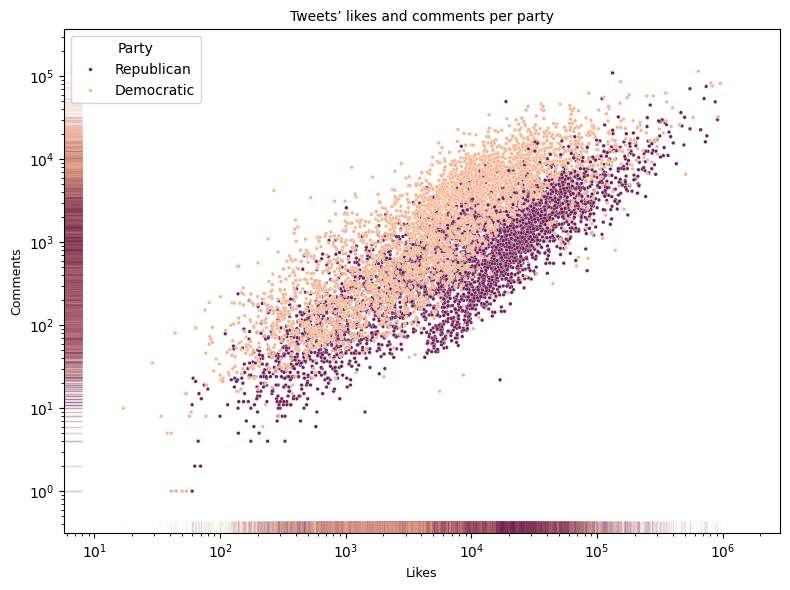

In [426]:
palette = sns.color_palette("rocket", n_colors=6)
colors = [palette[1], palette[5]]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=new_df, x='n_hearts', y='n_comments', s=7, hue='party', palette=colors)
sns.rugplot(data=new_df, x='n_hearts', y='n_comments', alpha=.1, hue='party', palette=colors)

plt.xscale('log')
plt.yscale('log')

plt.title('Tweets’ likes and comments per party', fontsize=10)
plt.xlabel('Likes', fontsize=9)
plt.ylabel('Comments', fontsize=9)
plt.legend(title='Party')
plt.tight_layout()
plt.show()

Очень интересно! Кажется, республиканцы в среднем получают больше комментариев, чем демократы, а демократы, наоборот, в среднем получают больше лайков, чем республиканцы. Это в целом видно по scatter графику, но еще заметнее на rugplotе. В любом случае точно нельзя сказать, что данные хорошо разделимы.

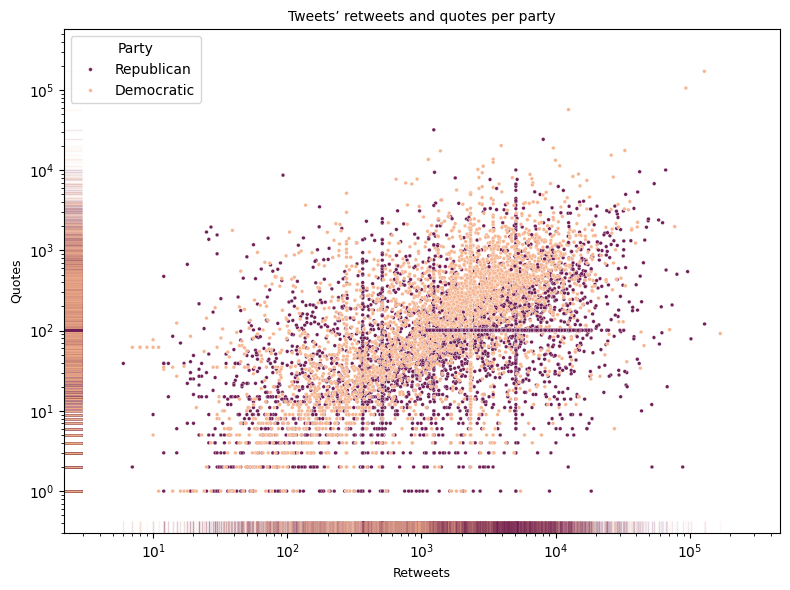

In [425]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=new_df, x='n_retweets', y='n_quotes', s=7, hue='party', palette=colors)
sns.rugplot(data=new_df, x='n_retweets', y='n_quotes', alpha=.1, hue='party', palette=colors)

plt.xscale('log')
plt.yscale('log')

plt.title('Tweets’ retweets and quotes per party', fontsize=10)
plt.xlabel('Retweets', fontsize=9)
plt.ylabel('Quotes', fontsize=9)
plt.legend(title='Party')
plt.tight_layout()
plt.show()

Эти полосы $-$ артефакты наших восстановленных данных. Стоит признать, что эти данные достаточно плохи для визуального анализа.

**Вывод: гипотеза скорее подтвердилась**  
Кажется, что по лайкам, комментариям, ретвитам и цитированиям действительно сложно отделить демократов от республиканцев.

**4.3.&emsp;Гипотеза #3 $-$ облака слов (частотные слова)**  
Мы предполагаем, что у республиканцев и демократов будут примерно одинаковые наиболее частотные слова

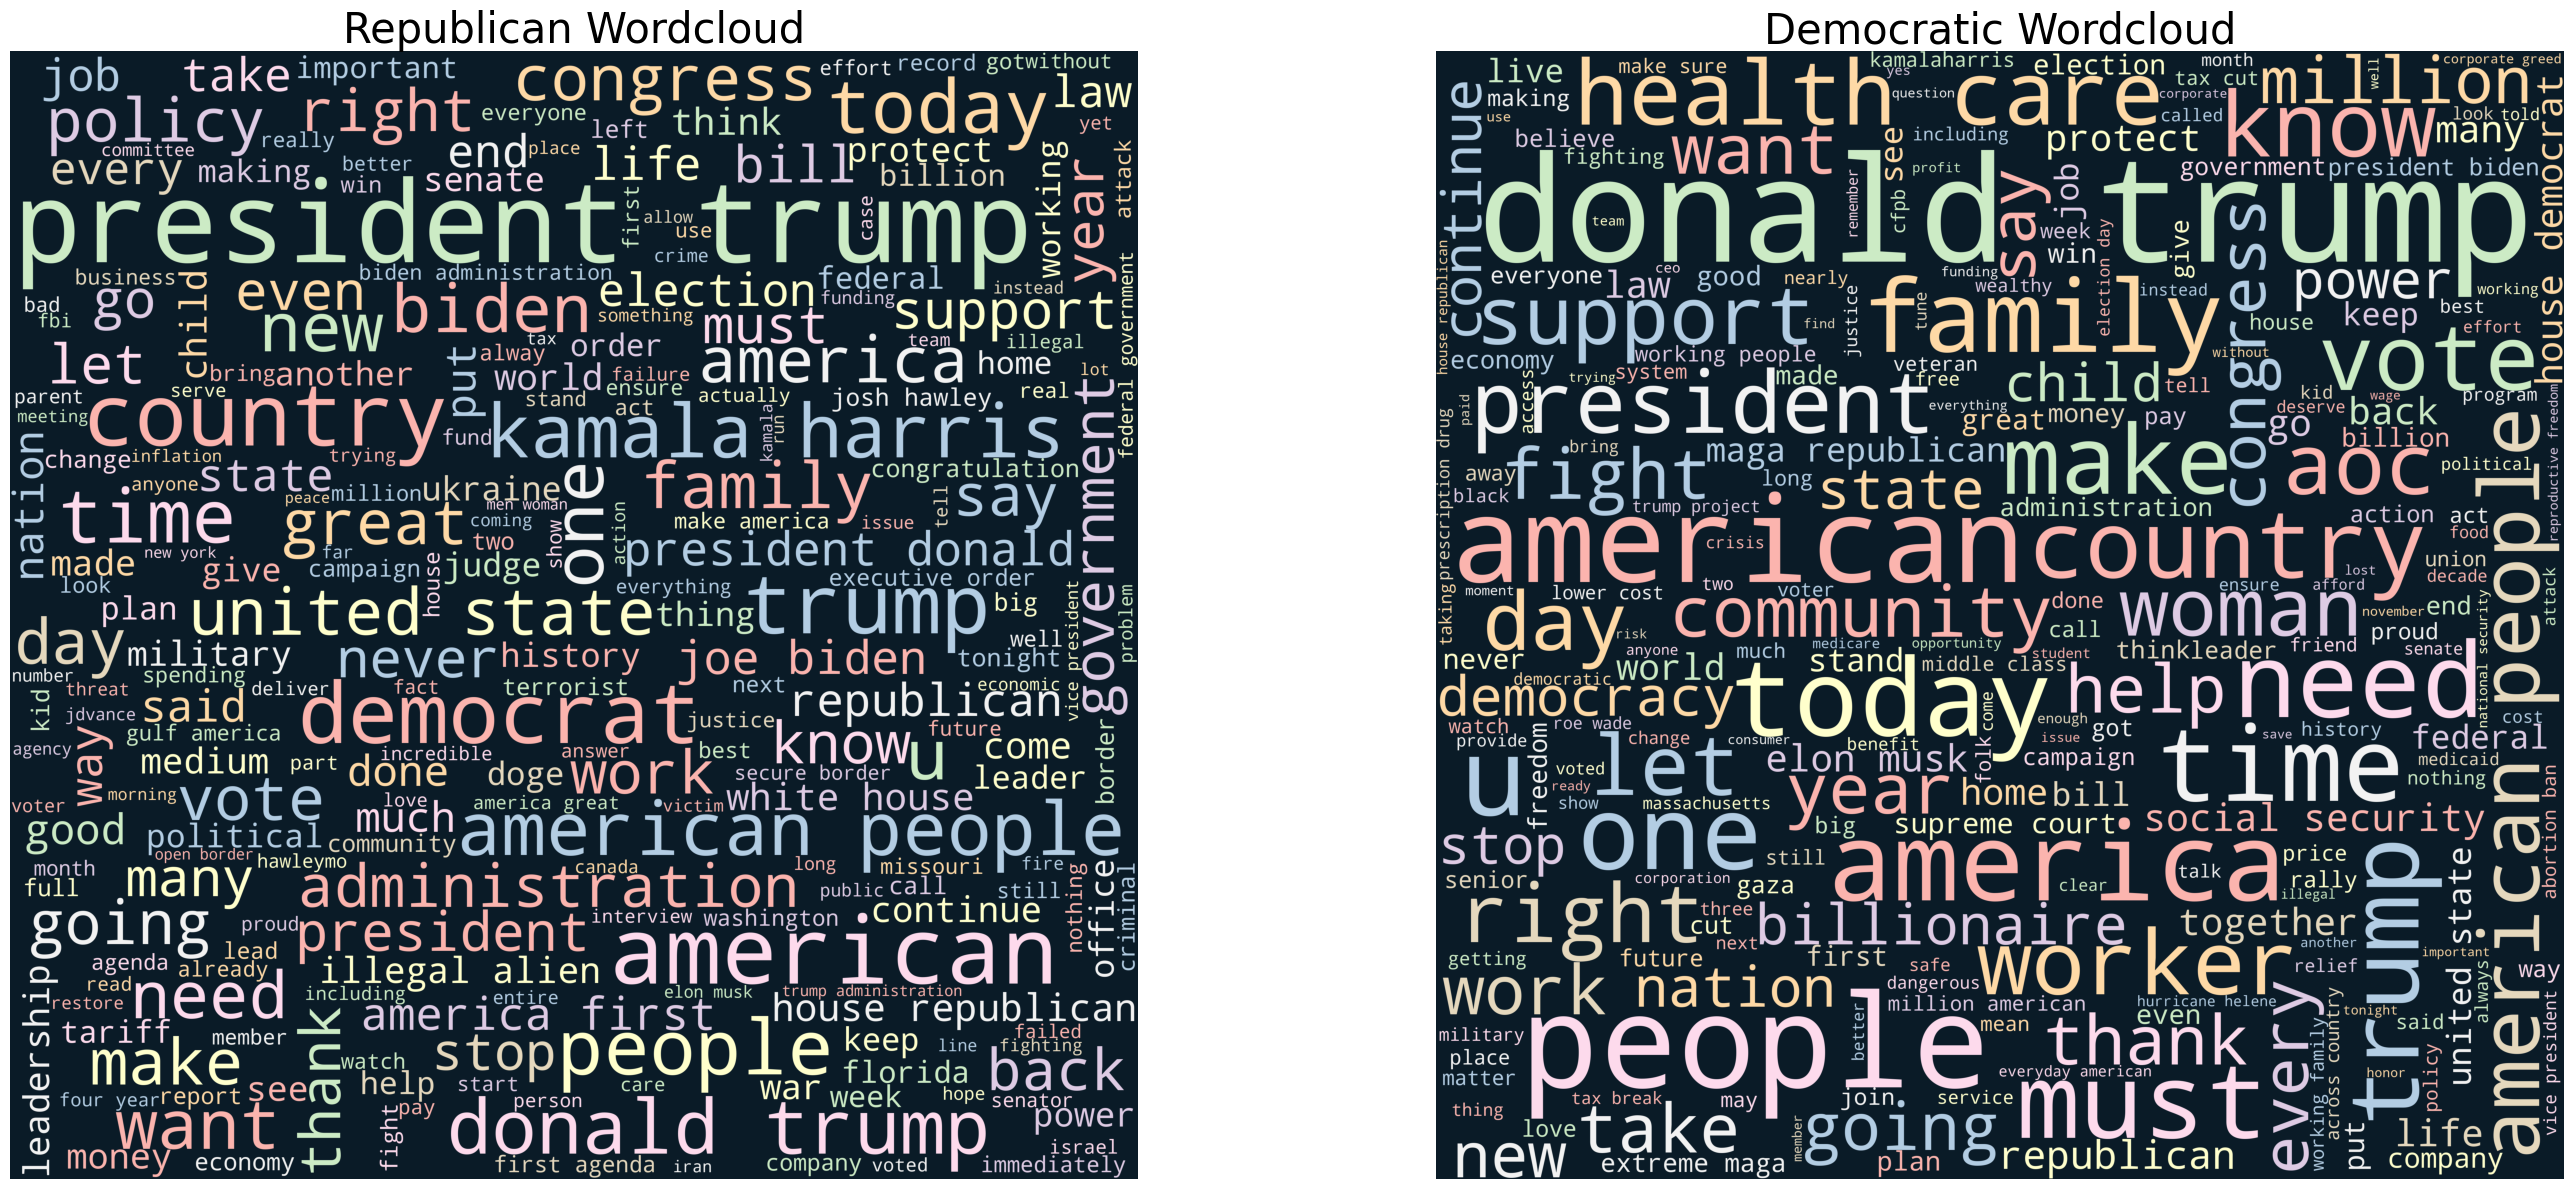

In [294]:
from wordcloud import WordCloud, STOPWORDS

# склеиваем тексты
rep_text = new_df['preprocessed'].where(new_df['party'] == 'Republican').str.cat(sep=' ')
dem_text = new_df['preprocessed'].where(new_df['party'] == 'Democratic').str.cat(sep=' ')

def wordcloud_maker(text: str):
    wordcloud = WordCloud(
        width=4000, 
        height=4000, 
        random_state=108,
        max_words=250,
        background_color='#0A1B27', 
        colormap='Pastel1', 
        collocations=True
    ).generate(text)
    return wordcloud

fig, axes = plt.subplots(1, 2, figsize=(30, 12))

axes[0].imshow(wordcloud_maker(rep_text))
axes[0].set_title('Republican Wordcloud', fontsize=30)
axes[0].axis('off')

axes[1].imshow(wordcloud_maker(dem_text))
axes[1].set_title('Democratic Wordcloud', fontsize=30)
axes[1].axis('off')

plt.tight_layout()
plt.show()

А теперь давайте посмотрим наиболее частотные уникальные слова и биграммы. Под уникальными словами мы понимаем те слова, которые встречаются в твитах одной партии и не встречаются в твитах другой партии, а также если разница в количестве употреблений больше, чем в два раза:

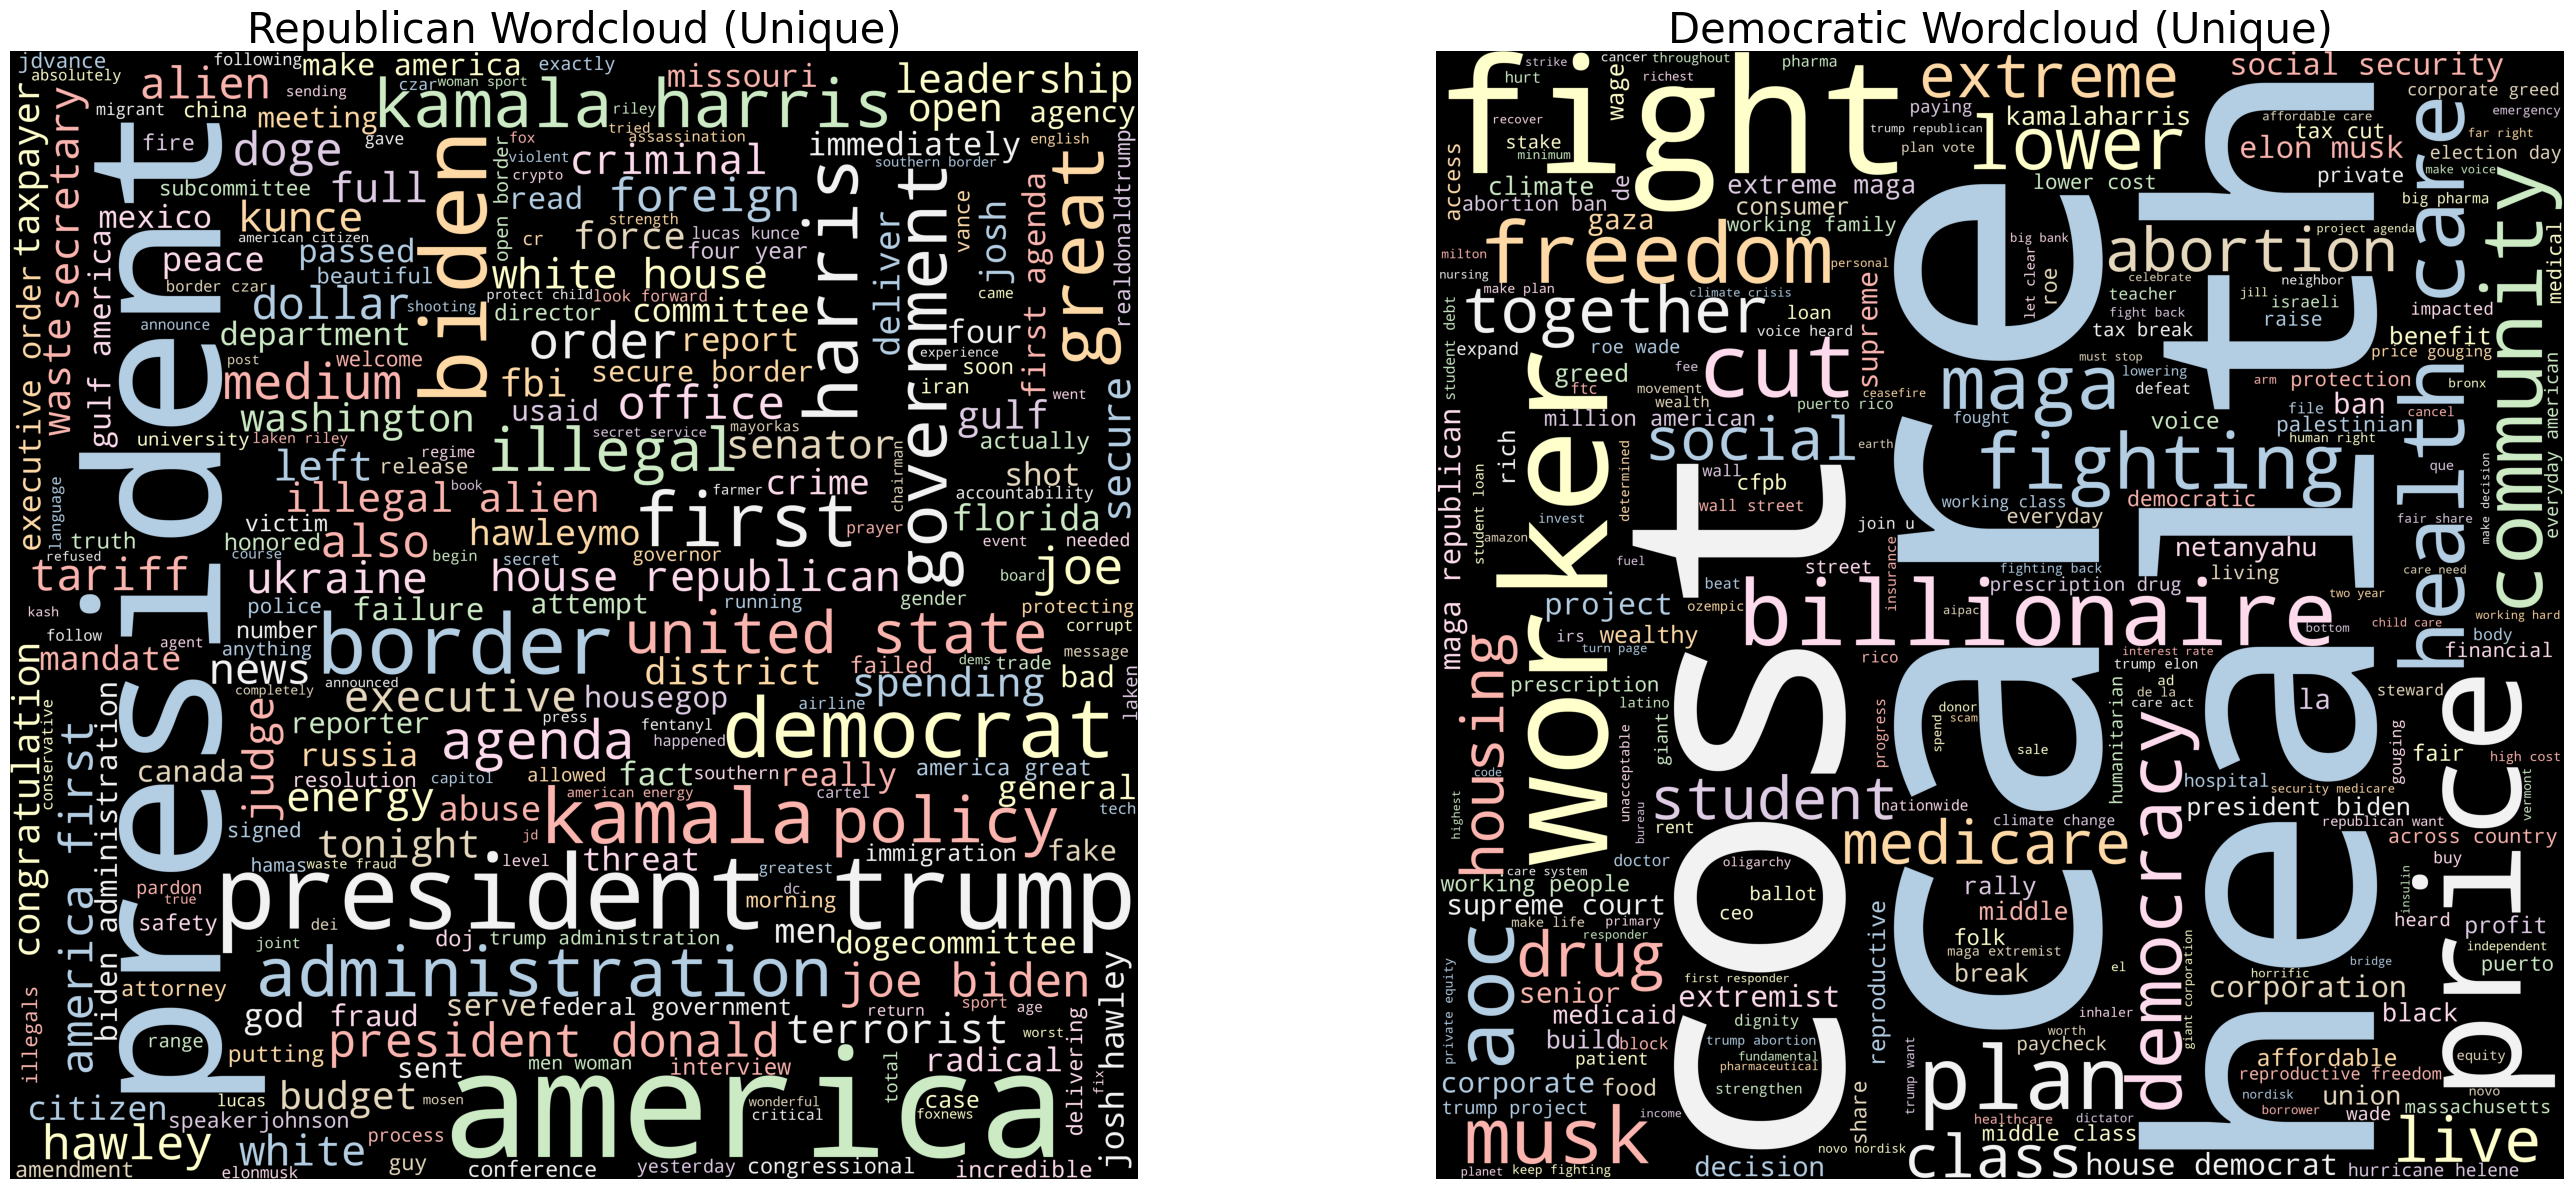

In [341]:
import itertools
from collections import Counter

# считаем вхождения каждого токена
single_rep = Counter(rep_text.split())
pair_rep = Counter([f'{x[0]} {x[1]}' for x in zip(rep_text.split(), rep_text.split()[1:])])
merged_rep = single_rep + pair_rep

single_dem = Counter(dem_text.split())
pair_dem = Counter([f'{x[0]} {x[1]}' for x in zip(dem_text.split(), dem_text.split()[1:])])
merged_dem = single_dem + pair_dem

# оставляем только уникальные для каждого текста токены (уникальные по нашим правилам)
unique_rep = {word: count for word, count in merged_rep.items() if count >= merged_dem[word] * 2}
unique_dem = {word: count for word, count in merged_dem.items() if count >= merged_rep[word] * 2}

def make_wordcloud(word_freq):
    wordcloud = WordCloud(
        width=4000, 
        height=4000, 
        random_state=108,
        max_words=250, 
        colormap='Pastel1',
    ).generate_from_frequencies(word_freq)
    
    return wordcloud

fig, axes = plt.subplots(1, 2, figsize=(30, 12))

axes[0].imshow(make_wordcloud(unique_rep))
axes[0].set_title('Republican Wordcloud (Unique)', fontsize=30)
axes[0].axis('off')

axes[1].imshow(make_wordcloud(unique_dem))
axes[1].set_title('Democratic Wordcloud (Unique)', fontsize=30)
axes[1].axis('off')

plt.tight_layout()
plt.show()

О да, у республиканцев есть illegal alien(-s)! (посередине) это очень весело: оказывается, у этого трамповского мема есть даже частотное подтверждение (в чем мем: Трамп называет нелегальных мигрантов нелегальными пришельцами; кажется, такой термин действительно прописан в законодательстве США, но просто Трамп его активно использует $-$ например, его [заявление](https://www.youtube.com/watch?v=lc9IC2wUh8A)).  
Частотные уникальные слова действительно отличаются! При этом мы видим, что как будто демократы больше говорят про здравоохранение, цены и экономику, а риторика республиканцев $-$ тарифы, границы, нелегальная миграция, DOGE, (военные) силы.

**Вывод: гипотеза частично подтвердилась**  
Кажется, что все-таки есть некоторые слова, которые почти однозначно маркируют демократов. Про республиканцев такое сказать труднее.

**4.4.&emsp;Гипотеза #4 $-$ тональность**  
Мы предполагаем, что тональность твитов республиканцев отрицательнее, чем твитов демократов

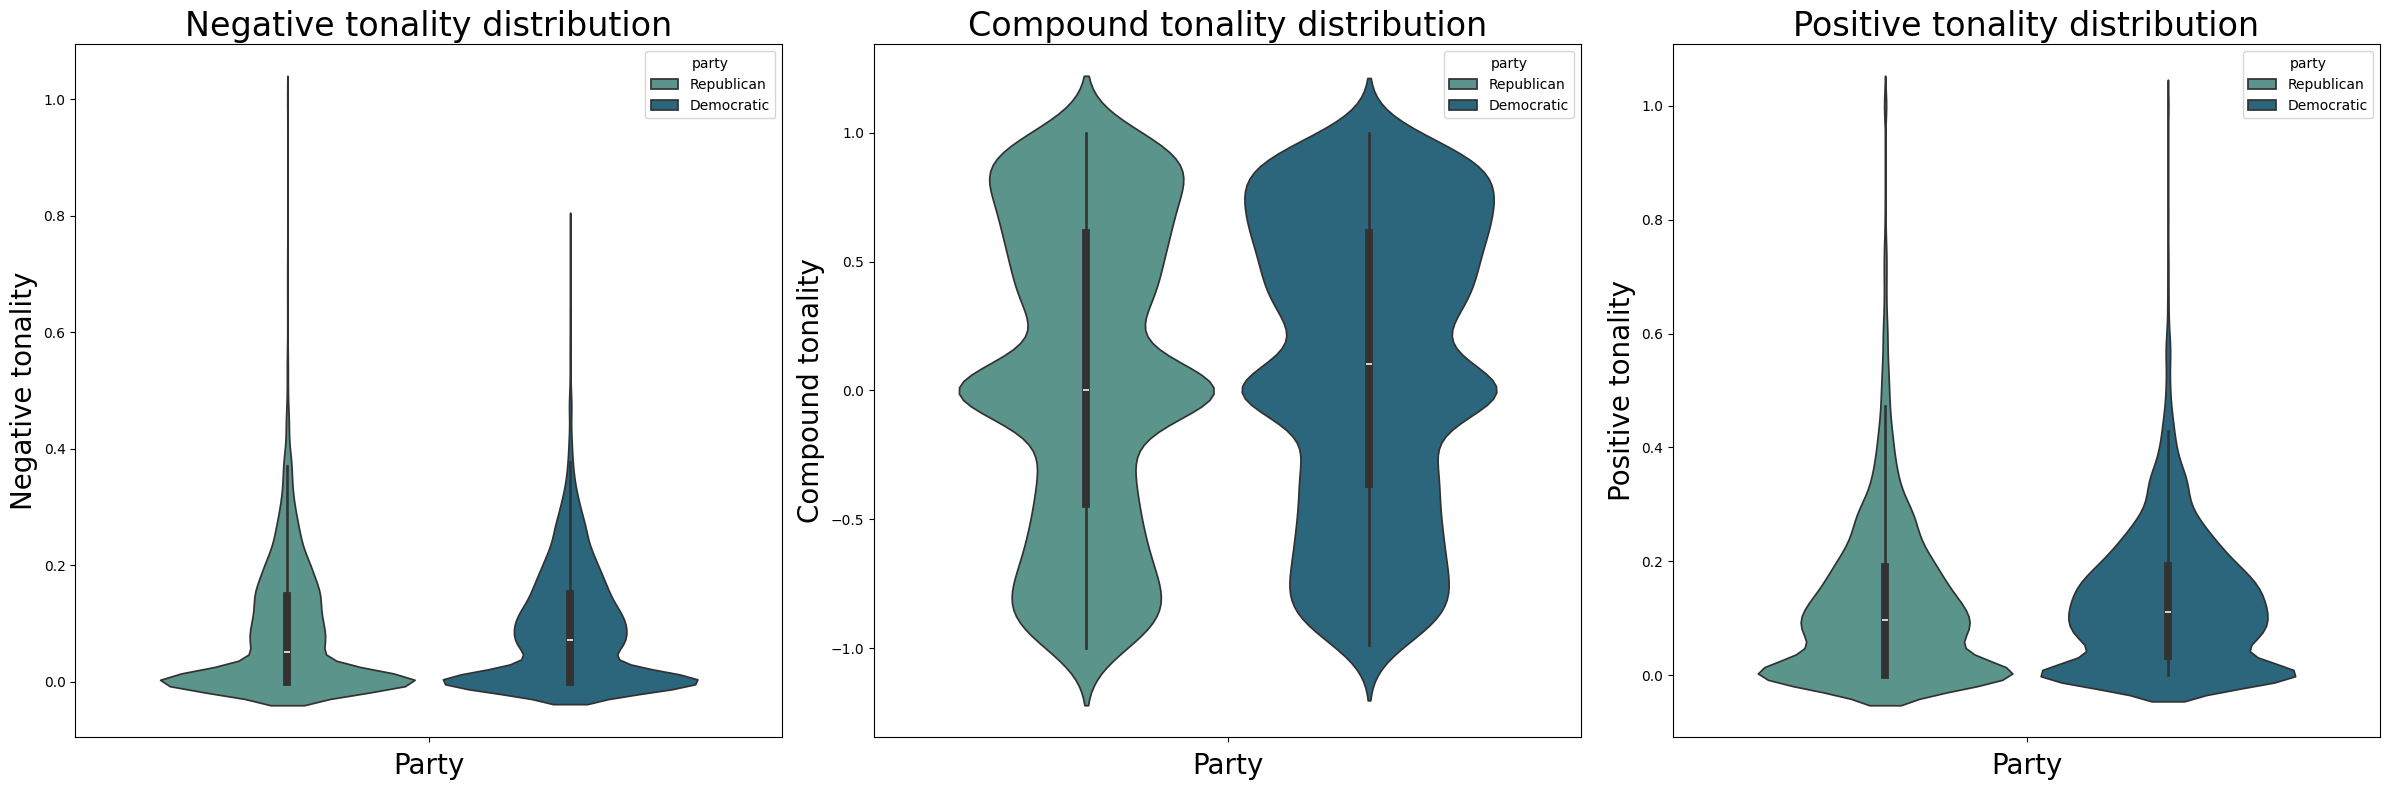

In [509]:
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

sns.violinplot(data=new_df, y='ton_neg', hue='party', palette='crest', gap=0.1, ax=axes[0])
sns.violinplot(data=new_df, y='ton_compound', hue='party', palette='crest', gap=0.1, ax=axes[1])
sns.violinplot(data=new_df, y='ton_pos', hue='party', palette='crest', gap=0.1, ax=axes[2])

axes[0].set_title('Negative tonality distribution', fontsize=24)
axes[0].set_xlabel('Party', fontsize=20)
axes[0].set_ylabel('Negative tonality', fontsize=20)

axes[1].set_title('Compound tonality distribution', fontsize=24)
axes[1].set_xlabel('Party', fontsize=20)
axes[1].set_ylabel('Compound tonality', fontsize=20)

axes[2].set_title('Positive tonality distribution', fontsize=24)
axes[2].set_xlabel('Party', fontsize=20)
axes[2].set_ylabel('Positive tonality', fontsize=20)

plt.tight_layout()
plt.show()

**Вывод: гипотеза не подтвердилась**  
Партии почти одинаковы в тональности твитов. Возможно, если приглядеться ко 2 графику (суммарное значение тональности), то можно заметить, что у демократов как будто чуть больше твитов с позитивной тональностью, чем у республиканцев. Однако все равно графики на удивление очень схожи.

**4.5.&emsp;Гипотеза #5 $-$ тональность-2**  
Мы предполагаем, что тональность твитов республиканцев принимает большее по модулю значение, чем у демократов (иными словами, их твиты более эмоциональные

**Вывод: гипотеза не подтвердилась**  
Думаю, по нарисованным графикам выше ясно, что даже если это и так, то перевес оказывается крайне незначительным. Но, кажется, все-таки демократы пишут чуть более позитивно окрашенные твиты, а республиканцы чуть менее.

**4.6.&emsp;Гипотеза #6 $-$ капслок**  
Мы предполагаем, что республиканцы чаще используют капслок, чем демократы

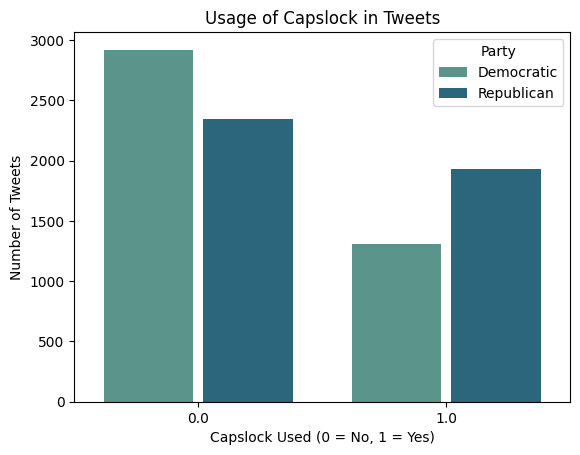

In [434]:
caps = new_df.where(new_df['text'] != '').groupby('party')['capslock'].value_counts().reset_index()

sns.barplot(data=caps, x='capslock', y='count', hue='party', palette='crest', gap=0.1)
plt.ylabel('Number of Tweets', fontsize=10)
plt.xlabel('Capslock Used (0 = No, 1 = Yes)', fontsize=10)
plt.legend(title='Party')
plt.title('Usage of Capslock in Tweets', fontsize=12)
plt.show()

**Вывод: гипотеза подтвердилась**  
Да, республиканцы действительно чаще используют капслок! Давайте посмотрим на реальные числа:

In [435]:
caps

party  capslock  count
0  Democratic       0.0   2920
1  Democratic       1.0   1308
2  Republican       0.0   2347
3  Republican       1.0   1933

**4.7.&emsp;Гипотеза #7 $-$ капслок-2**  
Мы предполагаем, что Дональд Трамп чаще остальных использует капслок

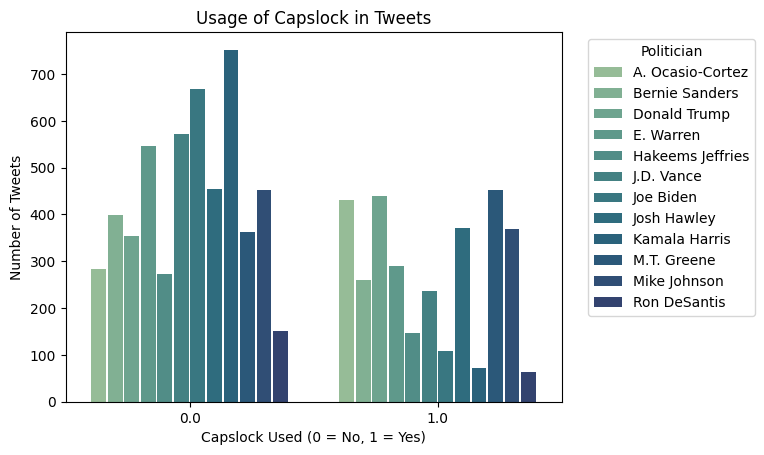

In [464]:
caps_politicians = new_df.where(new_df['text'] != '').groupby('name')['capslock'].value_counts().reset_index()

sns.barplot(data=caps_politicians, x='capslock', y='count', hue='name', palette='crest', gap=0.1)
plt.ylabel('Number of Tweets', fontsize=10)
plt.xlabel('Capslock Used (0 = No, 1 = Yes)', fontsize=10)
plt.legend(title='Politician', bbox_to_anchor=(1.04, 1))
plt.title('Usage of Capslock in Tweets', fontsize=12)
plt.show()

В реальных цифрах Дональда Трампа опережает тоже респуликанка M.T. Greene. Давайте посмотрим на процентное соотношение:

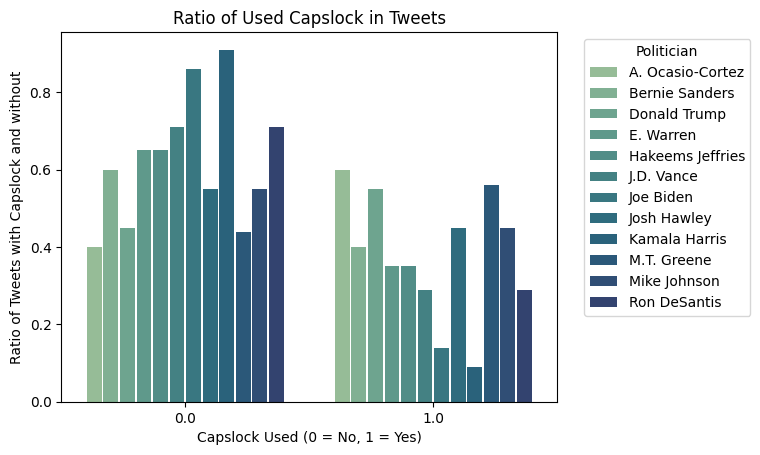

In [467]:
caps_politicians['total'] = caps_politicians.groupby('name')['count'].transform('sum')
caps_politicians['ratio'] = round(caps_politicians['count'] / caps_politicians['total'], 2)

sns.barplot(data=caps_politicians, x='capslock', y='ratio', hue='name', palette='crest', gap=0.1)
plt.ylabel('Ratio of Tweets with Capslock and without', fontsize=10)
plt.xlabel('Capslock Used (0 = No, 1 = Yes)', fontsize=10)
plt.legend(title='Politician', bbox_to_anchor=(1.04, 1))
plt.title('Ratio of Used Capslock in Tweets', fontsize=12)
plt.show()

**Вывод: гипотеза не подтвердилась**  
Эх, и даже так Трамп не на первом месте по количеству использованного капслока. Ну ничего, он еще попишет в свою соцсеть постов, время есть.

**4.8.&emsp;Выводы по EDA**  
Оказалось, что почти никакие данные не могут хорошо разделить твиты республиканцев и демократов, кроме, возможно, некоторых слов. Тем не менее эти данные все-таки важны для того, чтобы можно было попробовать классифицировать твиты совсем без текста. Однако, возможно, мы действительно просто удалим все 131 твит без текста, а имеющиеся числовые данные мы просто прибавим к векторам текстов.

### 3.&emsp;Разделение на выборки

**0.&emsp;Проверим сбалансированность классов**  

In [633]:
new_df.groupby('party').count()

name  username  text  timestamp  n_comments  n_retweets  n_quotes  \
party                                                                           
Democratic  4241      4241  4241       4241        4241        4241      4241   
Republican  4398      4398  4398       4398        4398        4398      4398   

            n_hearts  datetime  length  capslock  preprocessed  ton_neg  \
party                                                                     
Democratic      4241      4241    4241      4241          4241     4241   
Republican      4398      4398    4398      4398          4398     4398   

            ton_pos  ton_compound  
party                              
Democratic     4241          4241  
Republican     4398          4398

Классы (партии) сбалансированы!

**1.&emsp;Делим на выборки**  
Указываем `stratify`, потому что выборки не до конца равны

In [608]:
from mlxtend.plotting import plot_decision_regions
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder

data = new_df.loc[:, 'n_comments':'ton_compound'].drop('datetime', axis=1)
y = new_df['party']

data_train, data_test, y_train, y_test = train_test_split(data, y, test_size=0.3, stratify=y, random_state=102)

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

**2.&emsp;Нормализуем числовые значения**  
Важно нормализовывать числовые значения отдельно на тестовой и тренировочной выборках, чтобы не произошло переобучение

In [525]:
from sklearn.preprocessing import StandardScaler

normalizer = StandardScaler()

data_train_num = data_train.drop('preprocessed', axis=1)
data_test_num = data_test.drop('preprocessed', axis=1)

# масштабируем признаки отдельно на тренировочной выборке
data_train_norm_np = normalizer.fit_transform(data_train_num)
data_train_num = pd.DataFrame(data=data_train_norm_np, columns=data_train_num.columns)

# и на тестовой
data_test_norm_np = normalizer.transform(data_test_num)
data_test_num = pd.DataFrame(data=data_test_norm_np, columns=data_test_num.columns)

In [526]:
data_train_num.sample(2)

n_comments  n_retweets  n_quotes  n_hearts    length  capslock  \
127    -0.488512   -0.472132 -0.134615 -0.394283 -0.179113 -0.768698   
4717    1.332935   -0.193988  0.236523  1.343763  0.287215 -0.768698   

       ton_neg   ton_pos  ton_compound  
127  -0.847134  1.376694      1.402962  
4717  0.794915  0.044183     -1.012491

**3.&emsp;Векторизуем текстовые данные с помощью `TfidfVectorizer`**

In [531]:
vectorizer = TfidfVectorizer()

In [538]:
data_train_text = data_train['preprocessed']
data_test_text = data_test['preprocessed']

X_train_cv = vectorizer.fit_transform(data_train_text)
X_test_cv = vectorizer.transform(data_test_text)

In [539]:
print(X_train_cv.shape, X_test_cv.shape)

(6047, 11149) (2592, 11149)


**4.&emsp;А теперь объединим векторизованные текстовые данные с числовыми**  
На самом деле это большой вопрос, как работать вместе с векторизованными текстовыми и числовыми значениями. У нас были варианты:
- создать две модели, чтобы одна работала с векторизованными представлениями твитов, а другая $-$ с числовыми значениями  
$-$ проблема в том, что, как показал EDA, числовые значения почти никак не помогают при классификации твитов  
- вообще убрать числовые значения  
$-$ однако все же это до некоторой степени важные данные: модель сама поймет, как расставить веса так, чтобы использовать только важные признаки
- объединить вектора твитов и отнормированные числовые значения  
$-$ кажется, это оптимальный вариант: мы не теряем данные и при этом не возлагаем на них особо надежд ахах

In [540]:
from scipy.sparse import hstack

X_train_cv = hstack([X_train_cv, data_train_num.to_numpy()])
X_test_cv = hstack([X_test_cv, data_test_num.to_numpy()])

print(X_train_cv.shape, X_test_cv.shape)

(6047, 11158) (2592, 11158)


**5.&emsp;Векторизуем текстовые данные с помощью `spacy` и объединим их с числовыми значениями**  
Попробуем векторизовать также с помощью библиотеки `spacy`: предположительно вектора будут точнее отражать содержание твитов, потому что `spacy` использует уже готовый набор эмбеддингов, собранный со многих текстов, то есть использует не только наши твиты, как простые векторизаторы.

In [548]:
# !python -m spacy download en_core_web_md

In [550]:
import spacy

nlp = spacy.load('en_core_web_md')

X_train_sp = np.array([nlp(text).vector for text in data_train_text])
X_test_sp = np.array([nlp(text).vector for text in data_test_text])

In [551]:
X_train_sp = np.hstack([X_train_sp, data_train_num.to_numpy()])
X_test_sp = np.hstack([X_test_sp, data_test_num.to_numpy()])

print(X_train_sp.shape, X_test_sp.shape)

(6047, 309) (2592, 309)


### 4.&emsp;Обучение моделей  

Обучим три модели `kNN` и три модели логистической регрессии

**1.&emsp;Обучение модели kNN: данные, векторизованные `TF-IDF` методом**  
Сначала просто посмотрим, какие предсказания получаются на фиксированных `k`:

In [563]:
from sklearn.neighbors import KNeighborsClassifier

print(f'NN\tTrain\tTest')

for k in np.array([1, 3, 5, 10, 15, 25]):

    # дефолтно стоит метрика minlowski, p=2, что вместе как раз и дает евклидово расстояние
    cfl = KNeighborsClassifier(n_neighbors=k, n_jobs=10).fit(X_train_cv, y_train) 
    
    y_train_pred = cfl.predict(X_train_cv)
    y_test_pred = cfl.predict(X_test_cv)

    train_acc = np.mean(y_train_pred == y_train) 
    test_acc = np.mean(y_test_pred == y_test)

    print(f'k={k}\t{train_acc:.3f}\t{test_acc:.3f}')

NN	Train	Test
k=1	1.000	0.758
k=3	0.879	0.775
k=5	0.838	0.769
k=10	0.805	0.751
k=15	0.788	0.752
k=25	0.769	0.742


**Комментарий:**  
Ого, я опасался, что будет хуже. Accuracy 0.775 $-$ это здорово! Особенно если учитывать, что `baseline` нашей модели $-$ 50% (чисто статистически).  
Давайте попробуем приблизительно визуализировать работу `kNN`. Для того чтобы использовать визуализацию `plot_decision_regions` нам придется снизить размерность векторизованных данных с 11.5 тысяч до 2. Мы снизим размерность методом `t-SNE`, обучим заново модель и посмотрим на границы разделения:

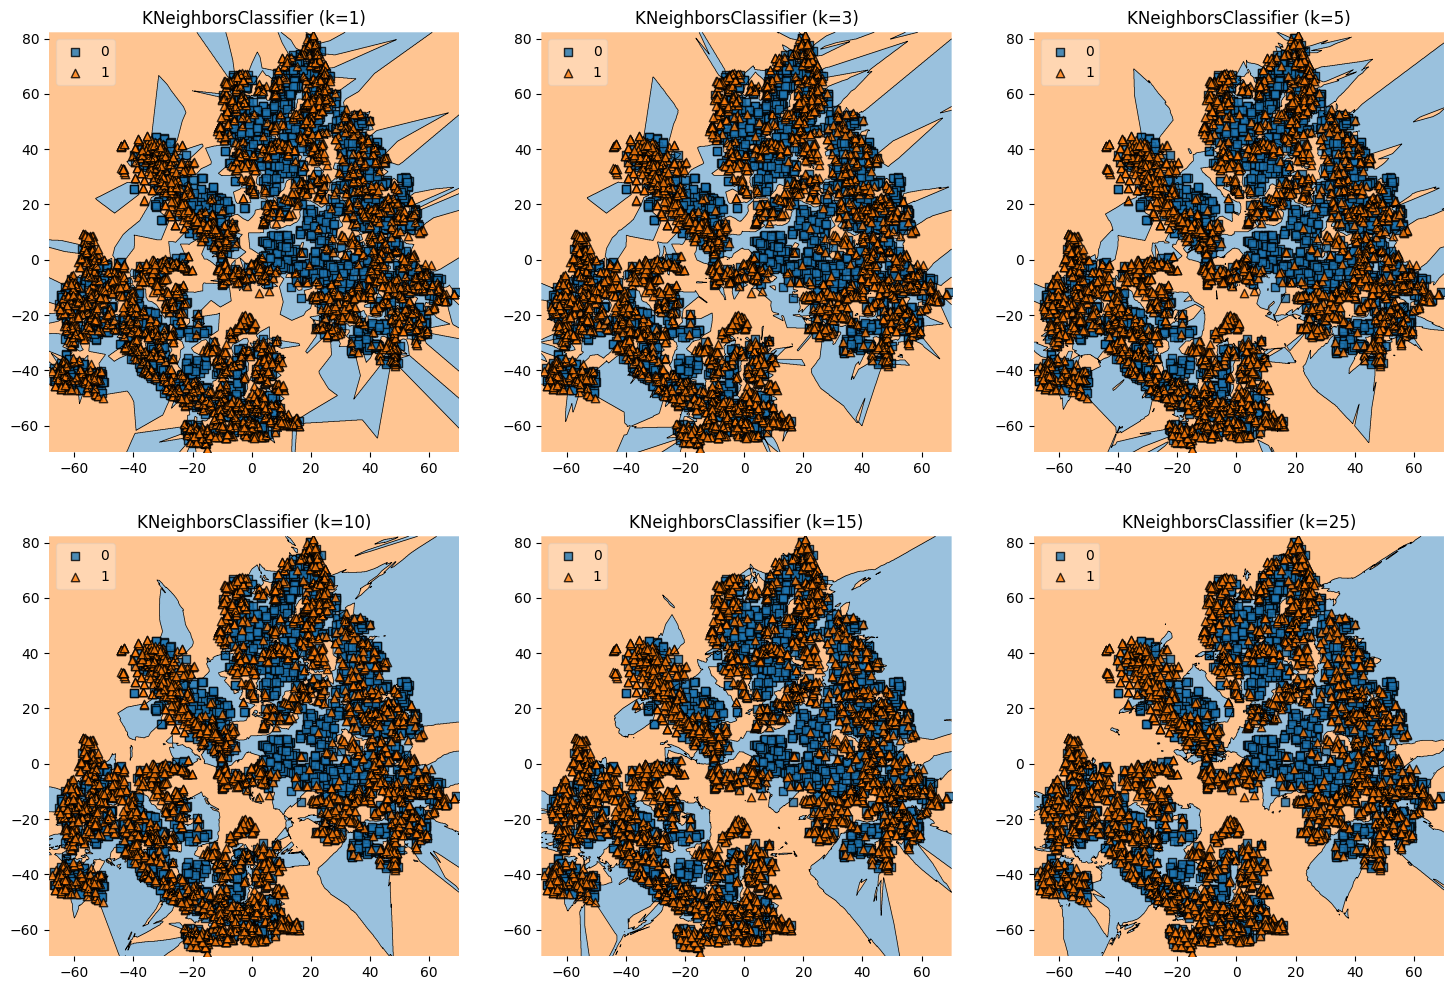

In [566]:
import mlxtend
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
X_train_cv_2d = tsne.fit_transform(X_train_cv.toarray())

gs = gridspec.GridSpec(2, 3)

fig = plt.figure(figsize=(18, 12))

labels = ['KNeighborsClassifier (k=1)',
          'KNeighborsClassifier (k=3)',
          'KNeighborsClassifier (k=5)',
          'KNeighborsClassifier (k=10)',
          'KNeighborsClassifier (k=15)',
          'KNeighborsClassifier (k=25)',]
for k, lab, grd in zip(np.array([1, 3, 5, 10, 15, 25]),
                       labels,
                       itertools.product([0, 1], [0, 1, 2])):

    clf = KNeighborsClassifier(n_neighbors=k, n_jobs=10).fit(X_train_cv_2d, y_train) 
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_train_cv_2d, y=y_train, clf=clf, legend=2)
    plt.title(lab)

plt.show()

**Комментарий:**  
Да, все-таки отображение ~8k объектов в пространстве сниженной размерности с ~11.5k до 2 оказывается не самым информативным. Однако так мы можем видеть, как кучно расположены твиты! Это немного отражает нашу интуицию, что в целом твиты республиканцев и демократов похожи друг на друга.  

**2.&emsp;Обучение модели kNN: данные, векторизованные `spacy`**  
Сначала просто посмотрим, какие предсказания получаются на фиксированных `k`:

In [567]:
from sklearn.neighbors import KNeighborsClassifier

print(f'NN\tTrain\tTest')

for k in np.array([1, 3, 5, 10, 15, 25]):

    # дефолтно стоит метрика minlowski, p=2, что вместе как раз и дает евклидово расстояние
    cfl = KNeighborsClassifier(n_neighbors=k, n_jobs=10).fit(X_train_sp, y_train) 
    
    y_train_pred = cfl.predict(X_train_sp)
    y_test_pred = cfl.predict(X_test_sp)

    train_acc = np.mean(y_train_pred == y_train) 
    test_acc = np.mean(y_test_pred == y_test)

    print(f'k={k}\t{train_acc:.3f}\t{test_acc:.3f}')

NN	Train	Test
k=1	1.000	0.738
k=3	0.875	0.758
k=5	0.849	0.760
k=10	0.816	0.769
k=15	0.808	0.764
k=25	0.789	0.767


**Комментарий:**  
Как и предыдущая модель, при увеличивающемся `k` модель на тренировочных данных показывает себя хуже, но не на тестовых данных. Лучший результат на тестовой выборке достигается при `k = 10`, тогда как прошлая модель показывала лучший результат при `k = 3`.

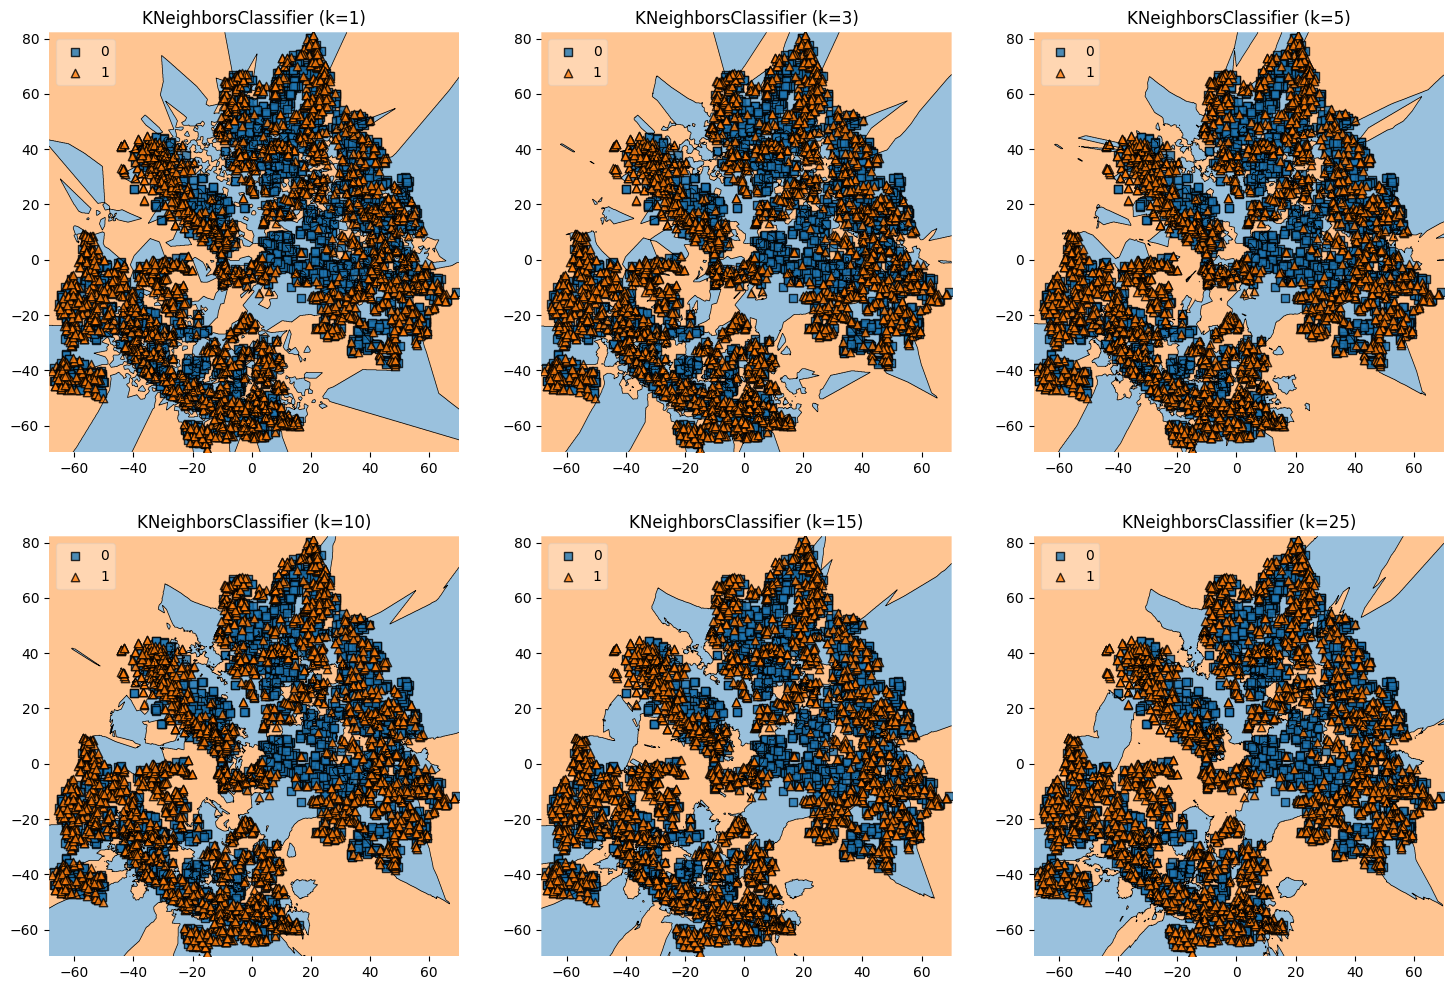

In [569]:
X_train_sp_2d = tsne.fit_transform(X_train_sp)

gs = gridspec.GridSpec(2, 3)
fig = plt.figure(figsize=(18, 12))

labels = ['KNeighborsClassifier (k=1)',
          'KNeighborsClassifier (k=3)',
          'KNeighborsClassifier (k=5)',
          'KNeighborsClassifier (k=10)',
          'KNeighborsClassifier (k=15)',
          'KNeighborsClassifier (k=25)',]
for k, lab, grd in zip(np.array([1, 3, 5, 10, 15, 25]),
                       labels,
                       itertools.product([0, 1], [0, 1, 2])):

    clf = KNeighborsClassifier(n_neighbors=k, n_jobs=10).fit(X_train_sp_2d, y_train) 
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_train_cv_2d, y=y_train, clf=clf, legend=2)
    plt.title(lab)

plt.show()

**Комментарий:**  
Кажется, что эти и предыдущие графики отличаются не очень сильно: как минимум, объекты сконцентрированы в тех же местах и имеют похожую плотность распределения. Возможно, это может что-то сказать нам про схожесть векторного представления `spacy` и `TF-IDF`, хотя очевидно, что после снижения размерности всякие тонкие различия между по-разному векторизованными представлениями твитов должны почти полностью пропасть.

**3.&emsp;Подбор гиперпараметров через `GridSearch`**  
Подберем оптимальные гиперпараметры для модели `kNN` и посмотрим, какие результаты они дают на тестовой выборке.

In [575]:
parameters = {
        'n_neighbors': np.arange(3, 70, 2).tolist(),
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski'],
        'p': [1, 2]
    }

knn = KNeighborsClassifier()
clf = GridSearchCV(knn, parameters, cv=5, verbose=1, n_jobs=-1);

**3.1.&emsp;Данные, векторизованные `TF-IDF`**

In [576]:
print(clf.fit(X_train_cv, y_train))

Fitting 5 folds for each of 408 candidates, totalling 2040 fits
GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23,
                                         25, 27, 29, 31, 33, 35, 37, 39, 41, 43,
                                         45, 47, 49, 51, 53, 55, 57, 59, 61, ...],
                         'p': [1, 2], 'weights': ['uniform', 'distance']},
             verbose=1)


In [582]:
cv_res_tfidf = pd.DataFrame(clf.cv_results_)[['params', 'mean_fit_time', 'mean_test_score', 'rank_test_score']]
cv_res_tfidf.sort_values('rank_test_score').head().style

In [578]:
knn_tfidf = clf.best_estimator_
pred_tfidf = knn_tfidf.predict(X_test_cv)
print(classification_report(pred_tfidf, y_test))

              precision    recall  f1-score   support

           0       0.76      0.78      0.77      1242
           1       0.79      0.77      0.78      1350

    accuracy                           0.78      2592
   macro avg       0.78      0.78      0.78      2592
weighted avg       0.78      0.78      0.78      2592



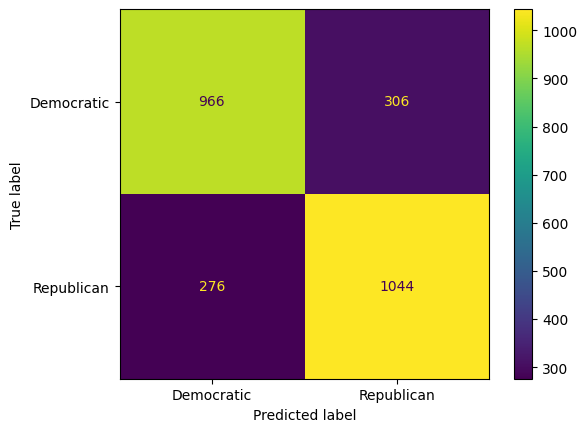

In [609]:
matrix = confusion_matrix(y_test, pred_tfidf, normalize=None)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=['Democratic', 'Republican'])
disp.plot();

**Комментарий:**  
`accuracy` составил 0.78, что выше, чем изначальной модели; но все равно в абсолютных значениях ошибка довольно значительная.

**3.2.&emsp;Данные, векторизованные `spacy`**

In [610]:
print(clf.fit(X_train_sp, y_train));

Fitting 5 folds for each of 408 candidates, totalling 2040 fits
GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23,
                                         25, 27, 29, 31, 33, 35, 37, 39, 41, 43,
                                         45, 47, 49, 51, 53, 55, 57, 59, 61, ...],
                         'p': [1, 2], 'weights': ['uniform', 'distance']},
             verbose=1)


In [611]:
cv_res_sp = pd.DataFrame(clf.cv_results_)[['params', 'mean_fit_time', 'mean_test_score', 'rank_test_score']]
cv_res_sp.sort_values('rank_test_score').head().style

In [613]:
knn_sp = clf.best_estimator_
pred_sp = knn_sp.predict(X_test_sp)
print(classification_report(pred_sp, y_test))

              precision    recall  f1-score   support

           0       0.70      0.82      0.75      1092
           1       0.85      0.75      0.79      1500

    accuracy                           0.77      2592
   macro avg       0.77      0.78      0.77      2592
weighted avg       0.78      0.77      0.78      2592



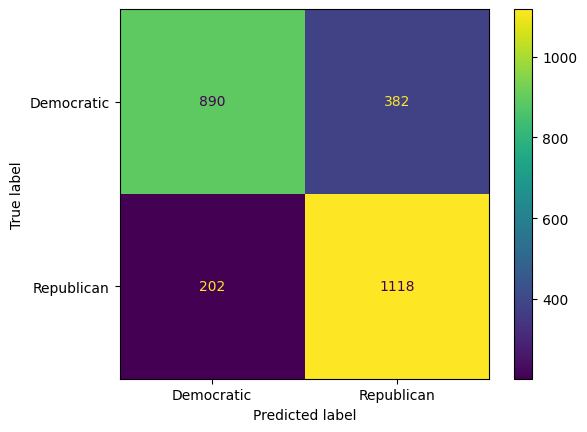

In [614]:
matrix = confusion_matrix(y_test, pred_sp, normalize=None)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=['Democratic', 'Republican'])
disp.plot();

**Комментарий:**  
Неожиданно, но модель показала себя чуть хуже: стала хуже определять демократические твиты, но лучше предсказывать республиканские. `Accuracy` = 0.77. Как мы увидим дальше на моделях логистической регрессии, данные, векторизованные `TF-IDF`, как ни странно давали лучшие результаты, чем `spacy`. В конце мы попробуем объяснить этот, на наш взгляд, необычный феномен.

**4.&emsp;Обучение модели логистической регрессии**  
Обучим модель логистической регрессии, подобрав гиперпараметры сразу через `GridSearchCV`

In [617]:
parameters = {
    'penalty': ['l1', 'l2', None],  # тип регуляризация
    'C':[0.001, 0.01, 0.1, 1, 10, 100],  # обратная сила регуляризации, ака чем меньше значение, тем больше штрафуем
    'solver': ['liblinear', 'lbfgs', 'saga'],  # алгоритм 
    'max_iter': [100, 200, 300],
}

logreg = LogisticRegression(random_state=102)
clf = GridSearchCV(logreg, parameters, cv=5, verbose=2, n_jobs=-1);

**4.1.&emsp;Данные, векторизованные `TF-IDF`**

In [618]:
%%time

clf.fit(X_train_cv, y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
CPU times: total: 2.61 s
Wall time: 4min 3s


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=102), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'max_iter': [100, 200, 300],
                         'penalty': ['l1', 'l2', None],
                         'solver': ['liblinear', 'lbfgs', 'saga']},
             verbose=2)

In [619]:
cv_res_tfidf_2 = pd.DataFrame(clf.cv_results_)[['params', 'mean_fit_time', 'mean_test_score', 'rank_test_score']]
cv_res_tfidf_2.sort_values('rank_test_score').head().style

In [620]:
logreg_tfidf = clf.best_estimator_
pred_tfidf_2 = logreg_tfidf.predict(X_test_cv)
print(classification_report(pred_tfidf_2, y_test))

              precision    recall  f1-score   support

           0       0.86      0.91      0.89      1202
           1       0.92      0.87      0.90      1390

    accuracy                           0.89      2592
   macro avg       0.89      0.89      0.89      2592
weighted avg       0.89      0.89      0.89      2592



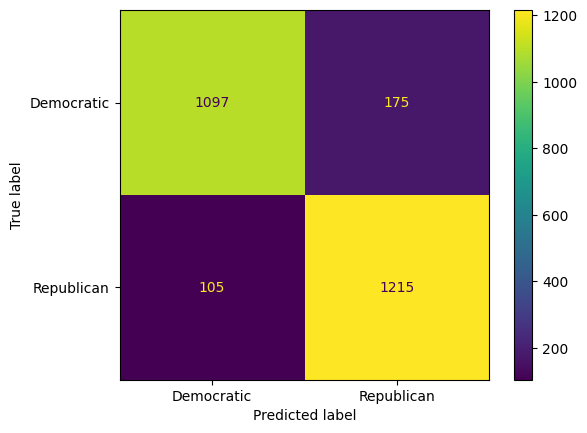

In [621]:
matrix = confusion_matrix(y_test, pred_tfidf_2, normalize=None)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=['Democratic', 'Republican'])
disp.plot();

**Комментарий:**  
Показатель `accuracy` составил поразительные 0.89 верных предсказаний на `TF-IDF` векторизованных данных! Учитывая, что 131 твит имеет пустую матрицы векторного представления (и лишь 9 последних столбцов в этих матрицах заполнены числовыми признаками), а сами твиты зачастую состоят не более чем из 60 слов, то это, на наш взгляд, удивительно хороший результат.

**4.2.&emsp;Данные, векторизованные `spacy`**

In [622]:
%%time

clf.fit(X_train_sp, y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
CPU times: total: 5.61 s
Wall time: 9min 29s


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=102), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'max_iter': [100, 200, 300],
                         'penalty': ['l1', 'l2', None],
                         'solver': ['liblinear', 'lbfgs', 'saga']},
             verbose=2)

In [623]:
cv_res_sp_2 = pd.DataFrame(clf.cv_results_)[['params', 'mean_fit_time', 'mean_test_score', 'rank_test_score']]
cv_res_sp_2.sort_values('rank_test_score').head().style

In [624]:
logreg_sp = clf.best_estimator_
pred_sp_2 = logreg_sp.predict(X_test_sp)
print(classification_report(pred_sp_2, y_test))

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      1260
           1       0.82      0.82      0.82      1332

    accuracy                           0.81      2592
   macro avg       0.81      0.81      0.81      2592
weighted avg       0.81      0.81      0.81      2592



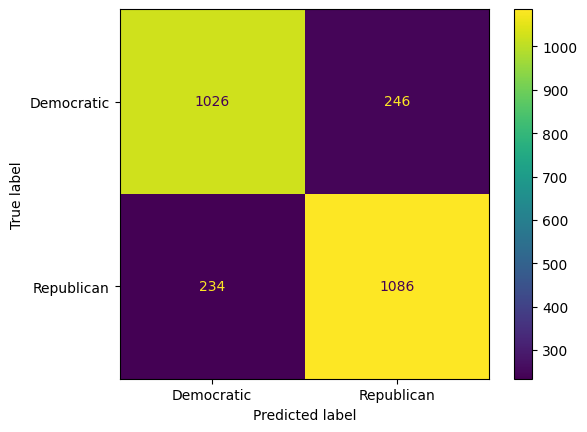

In [625]:
matrix = confusion_matrix(y_test, pred_sp_2, normalize=None)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=['Democratic', 'Republican'])
disp.plot();

**Комментарий:**  
И снова, как это ни удивительно, модель, обученная на данных, векторизованных `spacy`, показывает себя хуже: `accuracy score` составил 0.81.

**5.&emsp;Итог по обучению моделей**  
Лучшая модель (`accuracy = 0.89)` $-$ модель логистической регрессии, обученная на данных, векторизованных `TF-IDF`, с следующими значениями гиперпараметров:  
- подобранные:
  - C = 1   
  - max_iter = 100  
  - penalty = 'l2'  
  - solver = 'liblinear'  
  
- дефолтные:
  - tol = 0.0001  
  - fit_intercept = True  
  - intercept_scaling = 1  

In [626]:
logreg_tfidf

LogisticRegression(C=1, random_state=102, solver='liblinear')

### 5.&emsp;Результаты и выводы

Мы получили собрали твиты известных политиков демократов и республиканцев, подготовили данные, проанализировали некоторые признаки и обучили несколько моделей, классифицирующие твиты по 2 партиям.  

Во время сбора данных мы столкнулись с ограничением в ~800 твитов от одного политика. Это могло повлиять на точность наших моделей: финальный датасет состоит всего из 8639 строк $-$ 4241 демократический твит и 4398 республиканских твитов. 

Во время exploratory data analysis мы выдвинули несколько гипотез, проверка которых показала следующее:  
1. Демократы пишут твиты примерно одинаковой длины, а вот республиканцы примерно любой, хотя, как и демократы, чаще всего они пишут твиты длиной около 40 слов.
2. Политики получают примерно равное количество маркеров активности, хотя демократы в среднем больше лайков, а республиканцы больше комментариев.
3. Некоторые частотные слова и биграммы используются почти исключительно демократами; у республиканцев выделить действительно частотные слова скорее не получилось.
4. Твиты политиков обеих партий имеют примерно одинаковую тональность.
5. Республиканцы действительно чаще используют капслок в своих твитах.

Мы обучили несколько моделей методами `kNN` и логистической регрессии. Как оказалось, модели лучше показывали себя на текстовых данных, векторизованных методом `TF-IDF`, чем предобученной семантической моделью библиотеки `spaCy` для веб-текстов (твитов, блогов и пр.). Мы связываем это с тем, что, по всей видимости, какие-то слова, которые встречались в твитах, могли быть не зафиксированы в модели `spaCy`, в то время как `TfidfVectorizer` работает с текстовыми данными с нуля: то есть формирует словарь из слов и их векторного представления, исходя из фактического набора слов, встречающихся во всех твитах.  

Обученные модели показали высокий результат: ни одна из моделей не показала результат показателя `accuracy` ниже 75%, учитывая, что 131 текст (1.5%) не содержал слов. Возможно, удалив эти данные, мы бы могли лишь повысить точность модели. Лучший результат показала модель логистической регрессии с `accuracy = 0.89`.  

Исследование можно еще продолжить: в частности, расширив датасет, сделав его более сбалансированным по политикам разных уровней (федерального, регионального) и, возможно, добавив некоторые другие партии (Либертарианскую партию, партию зеленых). Более того, большой методологической трудностью является выбор "срока годности" твитов: на это значительно влияет политический и социальный контекст.  
Помимо этого, возможно, имеет смысл обучить и другие классифицирующие модели: `RandomForest`, `SVM`, `DecisionTree` и другие.  
Также было бы интересно проверить некоторые другие гипотезы: можно ли отделить твиты Дональда Трампа от всех остальных твитов? Можно ли отличить твиты, написанные в течение периода t до выборов и периода t после них? Как во время предвыборной кампании влияют твиты политиков на предпочтения избирателей?   

Как нам кажется, задача `Elephant — Donkey Problem` решена успешно.